In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# global path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'

In [3]:
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure1/'

# Data: CMAP2020

In [4]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [5]:
skcm_sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/SKCM/skcm_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [6]:
# shRNA perturbations that targeting these genes should be able to inhibit the expression of sig_defc_91061_up
## read original lv5 signature matrix
skcm_trt_sh_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_sh_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_sh_original.index = skcm_trt_sh_original.index.astype(int)
skcm_trt_sh_original = skcm_trt_sh_original[skcm_trt_sh_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [7]:
# compound perturbations
## read original lv5 signature matrix
skcm_trt_cp_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_cp_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_cp_original.index = skcm_trt_cp_original.index.astype(int)
skcm_trt_cp_original = skcm_trt_cp_original[skcm_trt_cp_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [8]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
1-EBIO,BRD-K70586315,NaN,NaN,CCn1c2ccccc2[nH]c1=O,CXUCKELNYMZTRT-UHFFFAOYSA-N,NaN
1-HYDROXYANTHRAQUINONE,BRD-K62620932,NaN,NaN,NaN,NaN,NaN
1-HYDROXYPHENAZINE,BRD-K66151076,NaN,NaN,NaN,NaN,NaN
1-NAPHTHYLAMINE,BRD-K05741221,NaN,NaN,NaN,NaN,NaN
1-NITRONAPHTHALENE,BRD-K72839221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
zolpidem,BRD-K44876623,GABRA1,Benzodiazepine receptor agonist,CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,NaN
zonisamide,BRD-A28095882,SCN11A,Sodium channel blocker,CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N,KZFDKINRISJFCO-UHFFFAOYSA-N,NaN
zopiclone,BRD-A34309505,GABRA1,GABA receptor agonist,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,GBBSUAFBMRNDJC-UHFFFAOYSA-N,NaN


In [9]:
compound_info['moa'].value_counts()

Dopamine receptor antagonist                          64
Cyclooxygenase inhibitor                              62
Adrenergic receptor antagonist                        56
Histamine receptor antagonist                         54
Serotonin receptor antagonist                         50
                                                      ..
CCK receptor ligand                                    1
Carbamoyl phosphate synthase activator                 1
Tripeptidyl peptidase inhibitor                        1
Intermediate conductance potassium channel blocker     1
WEE1 kinase inhibitor                                  1
Name: moa, Length: 581, dtype: int64

# Data: GSE91061

In [5]:
# GSE91061 original expression
expr_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_BMS038109Sample.hg19KnownGene.fpkm.csv',
                          index_col=0, header=0, sep=',')

In [6]:
expr_91061.shape

(22187, 109)

In [7]:
expr_91061

,Pt1_Pre_AD101148-6,Pt1_On_AD174047-6,Pt10_Pre_E9047565-6,Pt10_On_E9047632-6,Pt101_Pre_AD486328-5,Pt101_On_AD681975-5,Pt103_Pre_AE134058-2,Pt103_On_AE134059-6,Pt105_On_AE373241-6,Pt106_Pre_AD502250-5,...,Pt9_Pre_E9021024-6,Pt9_On_E9047644-7,Pt90_Pre_AD467873-6,Pt92_Pre_AE134060-5,Pt92_On_AE148750-5,Pt93_On_AE070988-5,Pt94_Pre_AD732850-6,Pt94_On_AE373242-6,Pt98_Pre_AD733586-8,Pt98_On_AE086717-6
1,2.943714,3.595545,1.189983,1.460591,1.785026,1.375918,7.734803,4.895584,1.084850,1.672253,...,1.062742,1.439649,2.606166,0.576973,1.387461,1.335126,1.959790,43.853104,1.890756,1.523350
10,0.000000,0.019562,0.000000,0.039176,0.000000,0.100569,0.000000,0.000000,0.000000,0.052896,...,0.187474,0.205179,0.000000,0.000000,0.000000,0.000000,0.021556,11.777745,0.000000,0.000000
100,10.027219,4.170643,10.017708,12.241966,27.412639,29.409310,19.336752,2.647676,11.945614,12.125976,...,6.106330,6.381909,13.046369,13.869151,21.216114,1.682833,9.543218,4.421732,3.790089,6.994346
1000,0.407255,0.040319,1.183365,3.737245,1.313282,2.645249,0.142493,0.020004,0.427601,16.134949,...,30.383779,37.943956,1.793913,3.697619,3.170839,0.256164,0.971044,10.310559,1.163395,0.832457
10000,25.274036,36.018795,46.562887,53.313169,8.721540,9.484339,5.047087,22.930653,16.334390,29.810245,...,29.089234,28.169557,13.643286,21.834762,18.416663,25.733070,19.154000,10.078965,21.396885,25.171776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,16.965789,18.667341,21.137840,25.747246,30.886756,33.412759,6.239696,14.267890,13.314332,14.072627,...,14.030045,12.760118,13.756137,17.142448,17.345828,25.492576,12.780802,8.109449,12.906046,16.826491
9992,0.812618,0.545436,0.312037,0.224884,0.288768,0.164944,0.000000,0.297139,2.381893,0.578362,...,0.990757,0.581252,0.152328,1.027950,0.334521,0.658582,0.459594,0.619786,0.443405,0.600486
9993,17.815880,17.014036,22.524965,15.910671,17.062000,17.218676,9.683801,44.249193,16.548169,16.505063,...,16.054513,17.802720,10.964174,28.392757,17.645762,15.991433,15.392266,14.107856,14.109531,11.660228
9994,6.400214,8.110476,4.181956,5.084711,9.135489,9.103528,0.991609,3.695637,3.830822,4.285097,...,5.090835,4.823752,3.183242,5.519505,5.910208,3.984750,3.328742,2.150460,2.604018,2.689529


In [8]:
expr_91061 = expr_91061[expr_91061.index.isin(bing_landmark.index)]
expr_91061 = expr_91061.rename(index=bing_landmark['Official NCBI gene symbol'])

In [9]:
# overlap with the L1000 space
expr_91061 = expr_91061[expr_91061.index.isin(skcm_trt_cp_original.index)]

# read clinical information
info_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_patient_info.csv',
                          index_col=0, header=0, sep=',').T
print(expr_91061.shape, info_91061.shape)

NameError: name 'skcm_trt_cp_original' is not defined

In [15]:
# get the paired sample list
timepoint_91061 = df(columns=['Pre', 'On', 'response'])
for p in info_91061.index:
    tmp_cat = p.split('_')[1]
    tmp_p = p.split('_')[0]
    timepoint_91061.at[tmp_p, tmp_cat] = p
    timepoint_91061.at[tmp_p, 'response'] = info_91061.loc[p, 'response'].split(': ')[1]

# get the patients with paired samples
paired_91061 = timepoint_91061.dropna(axis=0, how='any')

print(timepoint_91061.shape, paired_91061.shape)

(65, 3) (43, 3)


In [16]:
response_lut = {'PD': 'crimson', 'SD': 'royalblue', 'PRCR': 'cornflowerblue', 'UNK': 'grey'}
patient_color = df(index=info_91061.index, columns=['response', 'response_color', 'time', 'time_color'])
for p in paired_91061.index:
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time'] = 'Pre'
    patient_color.at[paired_91061.loc[p, 'On'], 'time'] = 'On'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time_color'] = 'violet'
    patient_color.at[paired_91061.loc[p, 'On'], 'time_color'] = 'gold'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'On'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
    patient_color.at[paired_91061.loc[p, 'On'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
patient_color = patient_color.dropna(axis=0, how='any')

In [17]:
# add color for paired_91061
for p in paired_91061.index:
    paired_91061.at[p, 'response_color'] = response_lut[paired_91061.loc[p, 'response']]

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [18]:
paired_91061['response'].value_counts()

PD      18
SD      15
PRCR     9
UNK      1
Name: response, dtype: int64

In [19]:
log2exp2_91061 = np.log2(expr_91061 + 1) # log2FPKM

# collapse duplicates
log2exp2_91061 = log2exp2_91061.groupby(level=0).mean()

log2exp2_91061 = log2exp2_91061[log2exp2_91061 > 0.].dropna(axis=0, how='all').fillna(0.)
print(log2exp2_91061.shape)

(10157, 109)


# 1. Reprofile the GSE91061 DEG analysis

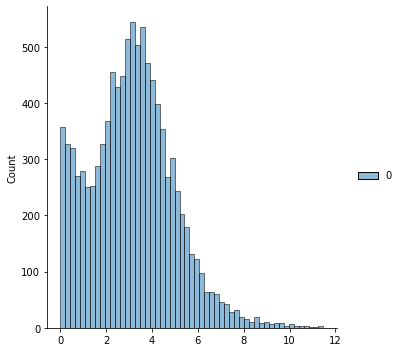

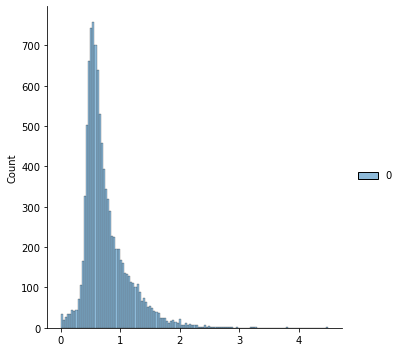

6011


In [20]:
# exclude low variance and low expr genes
log2exp2_91061_mean = df(log2exp2_91061.mean(axis=1))
log2exp2_91061_std = df(log2exp2_91061.std(axis=1))

sns.displot(log2exp2_91061_mean)
plt.show()

sns.displot(log2exp2_91061_std)
plt.show()

# mean > 2, std > .5
top_genes_mean = log2exp2_91061_mean[log2exp2_91061_mean[0] >= 2]
top_genes_std = log2exp2_91061_std[log2exp2_91061_std[0] >= 0.5]

top_genes = list(set(top_genes_mean.index) & set(top_genes_std.index))
print(len(top_genes))

In [21]:
log2exp2_91061_top = log2exp2_91061[log2exp2_91061.index.isin(top_genes)]

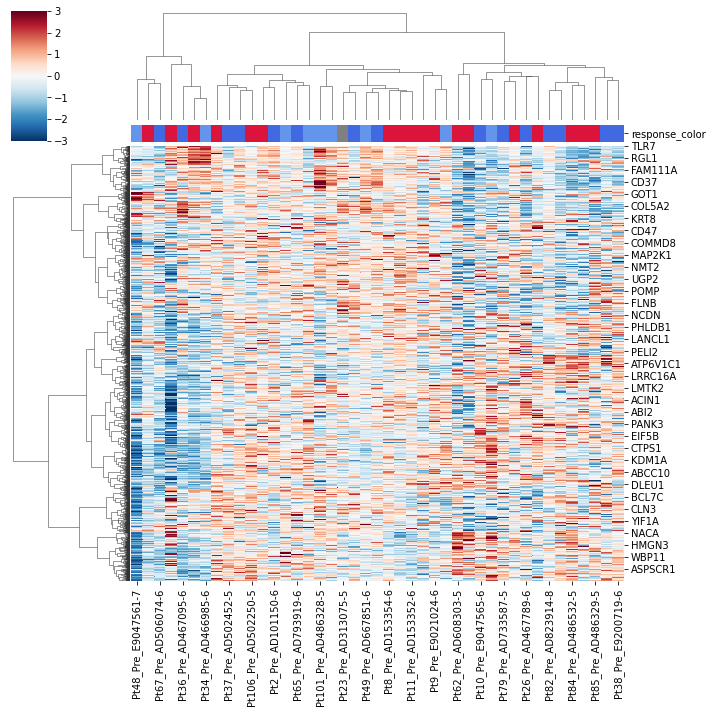

In [21]:
# differential between N and NR in pre-treatment
sns.clustermap(log2exp2_91061_top[paired_91061['Pre']],
               figsize=(10, 10),
               cmap='RdBu_r',
               z_score=0,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=patient_color['response_color'])
plt.show()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


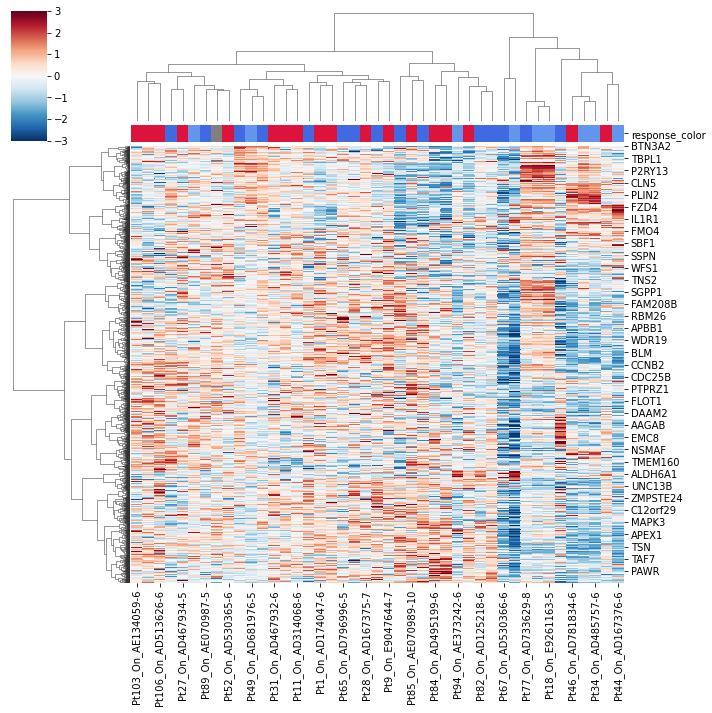

In [22]:
# differential between N and NR in on-treatment
sns.clustermap(log2exp2_91061_top[paired_91061['On']],
               figsize=(10, 10),
               cmap='RdBu_r',
               z_score=0,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=patient_color['response_color'])
plt.show()

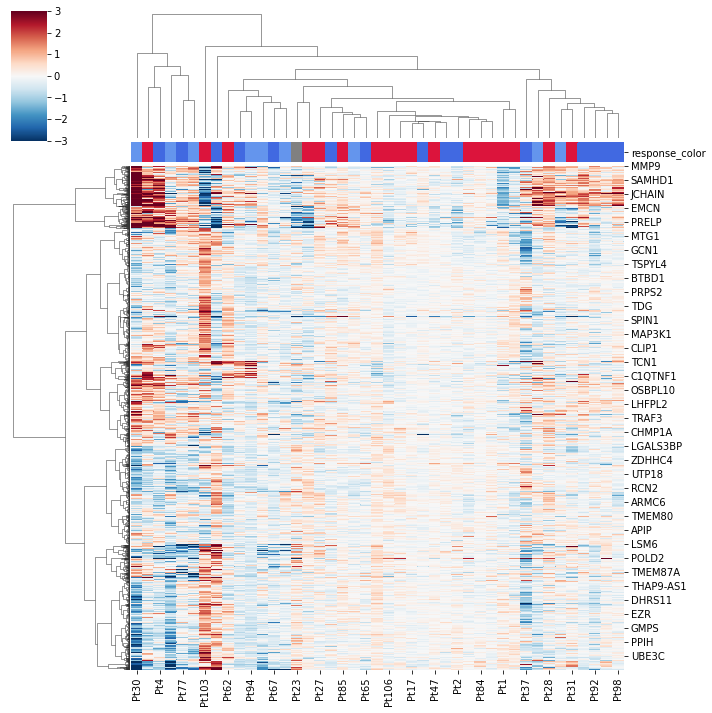

In [99]:
# differential between N and NR in On-treatment - Pre-treatment
log2exp2_91061_top_fc = df(index=log2exp2_91061_top.index, columns=paired_91061.index)
for p in log2exp2_91061_top_fc.columns:
    log2exp2_91061_top_fc[p] = log2exp2_91061_top[paired_91061.loc[p, 'On']] - log2exp2_91061_top[paired_91061.loc[p, 'Pre']]

sns.clustermap(log2exp2_91061_top_fc,
               figsize=(10, 10),
               cmap='RdBu_r',
               z_score=None,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=paired_91061['response_color'])
plt.show()

## 1.1 DEGs between Pre, On and On - Pre

In [32]:
# compare two conditions, non-paired
def deg_wo_paired(l_post, l_pre):
    '''
    Compare through differentially expressed genes.
    l_post, l_pre: dataframe, expression matrix in selected gene space
    '''
    # DEGs in landmark space
    ranksum_landmark = df(columns=['log2FC(P-N)', 'ranksum_stat', 'ranksum_p'])
    for g in l_post.index:
        tmp_post = l_post.loc[g, :]
        tmp_pre = l_pre.loc[g, :]
        ranksum_landmark.at[g, 'log2FC(P-N)'] = tmp_post.mean() - tmp_pre.mean()
        ranksum_landmark.at[g, 'ranksum_stat'], ranksum_landmark.at[g, 'ranksum_p'] = stats.ranksums(tmp_post, tmp_pre)

    return ranksum_landmark

In [33]:
# compare NR and R in pre-treatment and on-treatment, without paired
deg_91061 = {}

tmp_NR_pre = paired_91061[paired_91061['response'].isin(['PD'])]['Pre']
tmp_R_pre = paired_91061[paired_91061['response'].isin(['PRCR', 'SD'])]['Pre']
deg_91061['pre'] = deg_wo_paired(l_post=log2exp2_91061[tmp_NR_pre],
                                                        l_pre=log2exp2_91061[tmp_R_pre])

tmp_NR_on = paired_91061[paired_91061['response'].isin(['PD'])]['On']
tmp_R_on = paired_91061[paired_91061['response'].isin(['PRCR', 'SD'])]['On']
deg_91061['on'] = deg_wo_paired(l_post=log2exp2_91061[tmp_NR_on],
                                                        l_pre=log2exp2_91061[tmp_R_on])

tmp_fc_NR = list(paired_91061[paired_91061['response'].isin(['PD'])].index)
tmp_fc_R = list(paired_91061[paired_91061['response'].isin(['SD', 'PRCR'])].index)
deg_91061['fc'] = deg_wo_paired(l_post=log2exp2_91061_top_fc[tmp_fc_NR],
                                                        l_pre=log2exp2_91061_top_fc[tmp_fc_R])

In [34]:
deg_91061['pre']['log10P'] = -np.log10(deg_91061['pre']['ranksum_p'].astype(float))
deg_91061['on']['log10P'] = -np.log10(deg_91061['on']['ranksum_p'].astype(float))
deg_91061['fc']['log10P'] = -np.log10(deg_91061['fc']['ranksum_p'].astype(float))

In [35]:
deg_91061['fc'].to_csv(panel_home + '/volcano/TEC_91061_DEG_all.csv', sep=',')

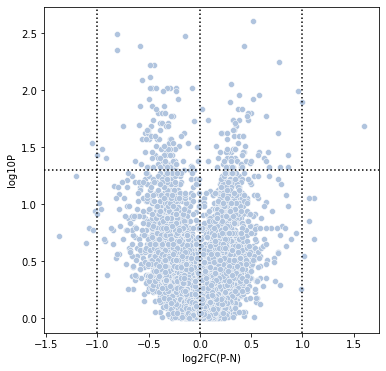

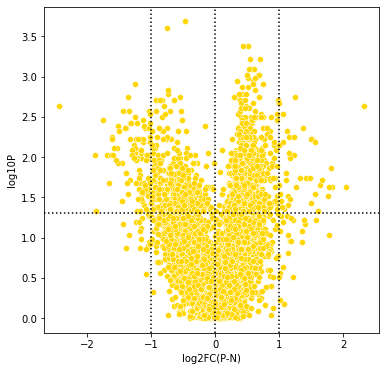

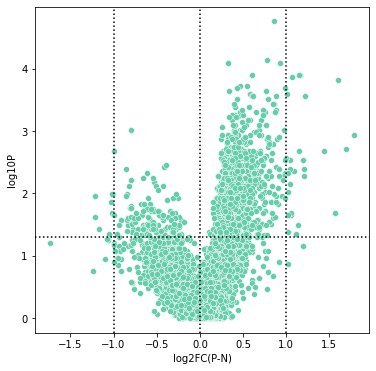

In [36]:
# volcano: pre
plt.figure(figsize=(6, 6))
sns.scatterplot(x='log2FC(P-N)', y='log10P', data=deg_91061['pre'], color='lightsteelblue')
plt.axvline(x=0., ls=':', c='k')
plt.axvline(x=1., ls=':', c='k')
plt.axvline(x=-1, ls=':', c='k')
plt.axhline(y=-np.log10(0.05), ls=':', c='k')
plt.show()

# volcano: on
plt.figure(figsize=(6, 6))
sns.scatterplot(x='log2FC(P-N)', y='log10P', data=deg_91061['on'], color='gold')
plt.axvline(x=0., ls=':', c='k')
plt.axvline(x=1., ls=':', c='k')
plt.axvline(x=-1, ls=':', c='k')
plt.axhline(y=-np.log10(0.05), ls=':', c='k')
plt.show()

# volcano: FC
plt.figure(figsize=(6, 6))
sns.scatterplot(x='log2FC(P-N)', y='log10P', data=deg_91061['fc'], color='mediumaquamarine')
plt.axvline(x=0., ls=':', c='k')
plt.axvline(x=1., ls=':', c='k')
plt.axvline(x=-1, ls=':', c='k')
plt.axhline(y=-np.log10(0.05), ls=':', c='k')
plt.show()

## 1.2 Contributions on patient response classification on 1st PCA

In [37]:
pre_91061_expr = log2exp2_91061_top[paired_91061['Pre']]
on_91061_expr = log2exp2_91061_top[paired_91061['On']]

In [38]:
# run PCA clustering on pre-treatment expression
pre_91061_pca = PCA(n_components=2, random_state=0, whiten=True).fit_transform(pre_91061_expr.T)
pre_91061_pca_coord = df(columns=['PCA-1', 'PCA-2'])
for i in range(len(paired_91061.index)):
    pre_91061_pca_coord.at[paired_91061.index[i], 'PCA-1'] = pre_91061_pca[i][0]
    pre_91061_pca_coord.at[paired_91061.index[i], 'PCA-2'] = pre_91061_pca[i][1]
pre_91061_pca_coord['response'] = paired_91061['response']

In [39]:
# run PCA clustering on on-treatment expression
on_91061_pca = PCA(n_components=2, random_state=0, whiten=True).fit_transform(on_91061_expr.T)
on_91061_pca_coord = df(columns=['PCA-1', 'PCA-2'])
for i in range(len(paired_91061.index)):
    on_91061_pca_coord.at[paired_91061.index[i], 'PCA-1'] = on_91061_pca[i][0]
    on_91061_pca_coord.at[paired_91061.index[i], 'PCA-2'] = on_91061_pca[i][1]
on_91061_pca_coord['response'] = paired_91061['response']

In [40]:
# run PCA clustering on foldchange
fc_91061_pca = PCA(n_components=2, random_state=0, whiten=True).fit_transform(log2exp2_91061_top_fc.T)
fc_91061_pca_coord = df(columns=['PCA-1', 'PCA-2'])
for i in range(len(log2exp2_91061_top_fc.columns)):
    fc_91061_pca_coord.at[log2exp2_91061_top_fc.columns[i], 'PCA-1'] = fc_91061_pca[i][0]
    fc_91061_pca_coord.at[log2exp2_91061_top_fc.columns[i], 'PCA-2'] = fc_91061_pca[i][1]
fc_91061_pca_coord['response'] = paired_91061['response']

In [41]:
pre_91061_pca_coord.to_csv(panel_home + 'PCA/pre_91061_pca_coord.csv', sep=',')
on_91061_pca_coord.to_csv(panel_home + 'PCA/on_91061_pca_coord.csv', sep=',')
fc_91061_pca_coord.to_csv(panel_home + 'PCA/fc_91061_pca_coord.csv', sep=',')

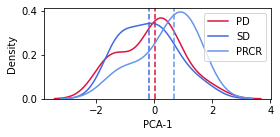

In [120]:
plt.figure(figsize=(4, 2))
for p in pre_91061_pca_coord['response'].unique():
    sns.kdeplot(pre_91061_pca_coord[pre_91061_pca_coord['response'] == p]['PCA-1'],
                label=p, color=response_lut[p])
    plt.axvline(x=pre_91061_pca_coord[pre_91061_pca_coord['response'] == p]['PCA-1'].median(),
                ls='--', c=response_lut[p])
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/pre_PCA_kde.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/pre_PCA_kde.png', dpi=300, transparent=True)
plt.show()

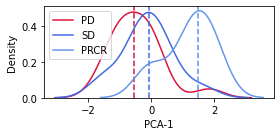

In [116]:
plt.figure(figsize=(4, 2))
for p in on_91061_pca_coord['response'].unique():
    sns.kdeplot(on_91061_pca_coord[on_91061_pca_coord['response'] == p]['PCA-1'],
                label=p, color=response_lut[p])
    plt.axvline(x=on_91061_pca_coord[on_91061_pca_coord['response'] == p]['PCA-1'].median(),
                ls='--', c=response_lut[p])
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/on_PCA_kde.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/on_PCA_kde.png', dpi=300, transparent=True)
plt.show()

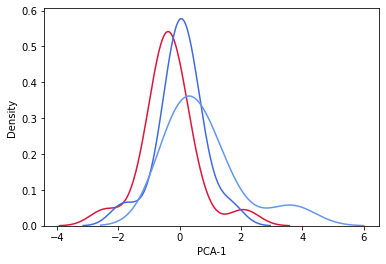

In [104]:
for p in fc_91061_pca_coord['response'].unique():
    sns.kdeplot(fc_91061_pca_coord[fc_91061_pca_coord['response'] == p]['PCA-1'],
                label=p, color=response_lut[p])
plt.show()

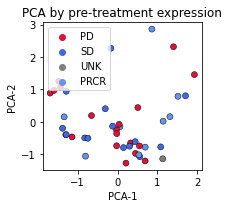

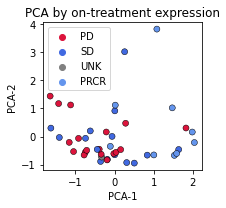

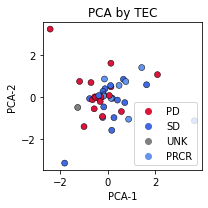

In [42]:
plt.figure(figsize=(3, 3))
sns.scatterplot(x='PCA-1',
                y='PCA-2',
                hue='response',
                edgecolor='k',
                palette=response_lut,
                data=pre_91061_pca_coord)
plt.title('PCA by pre-treatment expression')
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/pre_PCA_scatter.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/pre_PCA_scatter.png', dpi=300, transparent=True)
plt.show()

plt.figure(figsize=(3, 3))
sns.scatterplot(x='PCA-1',
                y='PCA-2',
                hue='response',
                edgecolor='k',
                palette=response_lut,
                data=on_91061_pca_coord)
plt.title('PCA by on-treatment expression')
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/on_PCA_scatter.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/on_PCA_scatter.png', dpi=300, transparent=True)
plt.show()

plt.figure(figsize=(3, 3))
sns.scatterplot(x='PCA-1',
                y='PCA-2',
                hue='response',
                edgecolor='k',
                palette=response_lut,
                data=fc_91061_pca_coord)
plt.title('PCA by TEC')
plt.legend(loc='best')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/fc_PCA_scatter.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/fc_PCA_scatter.png', dpi=300, transparent=True)
plt.show()

In [43]:
# add binary labels for responses
tmp_p_NR = list(paired_91061[paired_91061['response'].isin(['PD'])].index)
tmp_p_R = list(paired_91061[paired_91061['response'].isin(['SD', 'PRCR'])].index)

pre_91061_pca_coord.at[tmp_p_NR, 'response_binary'] =0
pre_91061_pca_coord.at[tmp_p_R, 'response_binary'] = 1

on_91061_pca_coord.at[tmp_p_NR, 'response_binary'] = 0
on_91061_pca_coord.at[tmp_p_R, 'response_binary'] = 1

fc_91061_pca_coord.at[tmp_p_NR, 'response_binary'] = 0
fc_91061_pca_coord.at[tmp_p_R, 'response_binary'] = 1

# remove UNK
pre_91061_pca_coord = pre_91061_pca_coord.dropna(axis=0, how='any')
on_91061_pca_coord = on_91061_pca_coord.dropna(axis=0, how='any')
fc_91061_pca_coord = fc_91061_pca_coord.dropna(axis=0, how='any')

In [44]:
# Visualize by ROC curve
# pre
fpr_pre, tpr_pre, _ = roc_curve(pre_91061_pca_coord['response_binary'], pre_91061_pca_coord['PCA-1'], pos_label=1)

# on
fpr_on, tpr_on, _ = roc_curve(on_91061_pca_coord['response_binary'], on_91061_pca_coord['PCA-1'], pos_label=1)

# fc
fpr_fc, tpr_fc, _ = roc_curve(fc_91061_pca_coord['response_binary'], fc_91061_pca_coord['PCA-1'], pos_label=1)

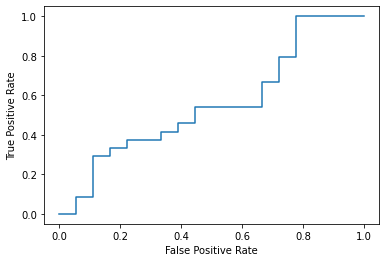

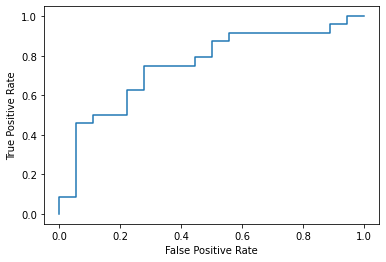

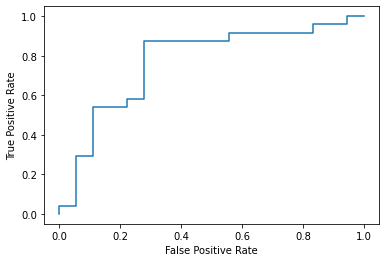

In [45]:
RocCurveDisplay(fpr=fpr_pre, tpr=tpr_pre).plot()
RocCurveDisplay(fpr=fpr_on, tpr=tpr_on).plot()
RocCurveDisplay(fpr=fpr_fc, tpr=tpr_fc).plot()

In [46]:
print(auc(fpr_pre, tpr_pre))
print(auc(fpr_on, tpr_on))
print(auc(fpr_fc, tpr_fc))

0.5532407407407407
0.7523148148148149
0.7708333333333333


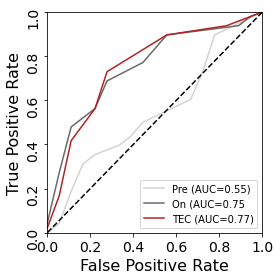

In [47]:
# merged ROC
plt.figure(figsize=(4, 4))

# add ROCs
g = sns.lineplot(x=fpr_pre,
                 y=tpr_pre,
                 ci=None,
                 color='lightgray',
                 label='Pre (AUC=' + str(np.round(auc(fpr_pre, tpr_pre), 2)) + ')')
g = sns.lineplot(x=fpr_on,
                 y=tpr_on,
                 ci=None,
                 color='dimgray',
                 label='On (AUC=' + str(np.round(auc(fpr_on, tpr_on), 2)))
g = sns.lineplot(x=fpr_fc,
                 y=tpr_fc,
                 ci=None,
                 color='firebrick',
                 label='TEC (AUC=' + str(np.round(auc(fpr_fc, tpr_fc), 2)) + ')')

# add x=y
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '--k')

# add labels
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.yticks(rotation=90, fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/AUC_PCA1.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/AUC_PCA1.png', dpi=300, transparent=True)

In [48]:
# ROC on PCA-2
# Visualize by ROC curve
# pre
fpr_pre_2, tpr_pre_2, _ = roc_curve(pre_91061_pca_coord['response_binary'], pre_91061_pca_coord['PCA-2'], pos_label=1)

# on
fpr_on_2, tpr_on_2, _ = roc_curve(on_91061_pca_coord['response_binary'], on_91061_pca_coord['PCA-2'], pos_label=1)

# fc
fpr_fc_2, tpr_fc_2, _ = roc_curve(fc_91061_pca_coord['response_binary'], fc_91061_pca_coord['PCA-2'], pos_label=1)

In [49]:
print(auc(fpr_pre_2, tpr_pre_2))
print(auc(fpr_on_2, tpr_on_2))
print(auc(fpr_fc_2, tpr_fc_2))

0.4398148148148149
0.4722222222222222
0.44907407407407407


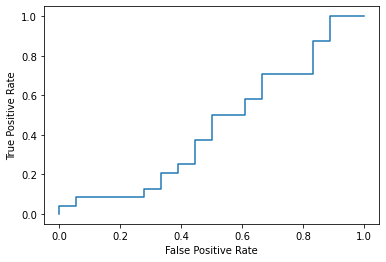

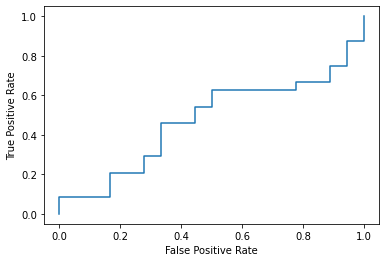

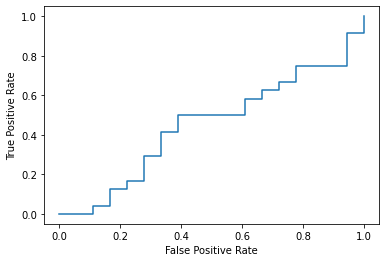

In [50]:
RocCurveDisplay(fpr=fpr_pre_2, tpr=tpr_pre_2).plot()
RocCurveDisplay(fpr=fpr_on_2, tpr=tpr_on_2).plot()
RocCurveDisplay(fpr=fpr_fc_2, tpr=tpr_fc_2).plot()

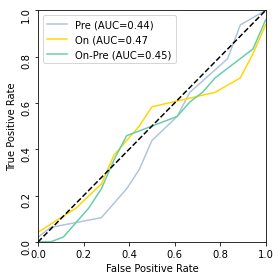

In [51]:
# merged ROC
plt.figure(figsize=(4, 4))

# add ROCs
g = sns.lineplot(x=fpr_pre_2,
                 y=tpr_pre_2,
                 ci=None,
                 color='lightsteelblue',
                 label='Pre (AUC=' + str(np.round(auc(fpr_pre_2, tpr_pre_2), 2)) + ')')
g = sns.lineplot(x=fpr_on_2,
                 y=tpr_on_2,
                 ci=None,
                 color='gold',
                 label='On (AUC=' + str(np.round(auc(fpr_on_2, tpr_on_2), 2)))
g = sns.lineplot(x=fpr_fc_2,
                 y=tpr_fc_2,
                 ci=None,
                 color='mediumaquamarine',
                 label='On-Pre (AUC=' + str(np.round(auc(fpr_fc_2, tpr_fc_2), 2)) + ')')

# add x=y
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '--k')

# add labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.yticks(rotation=90)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()

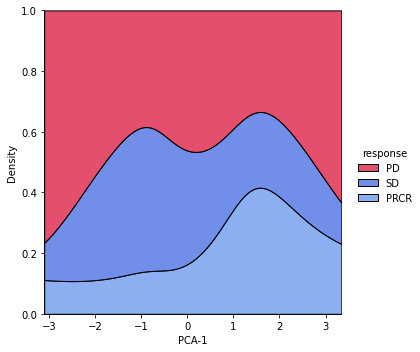

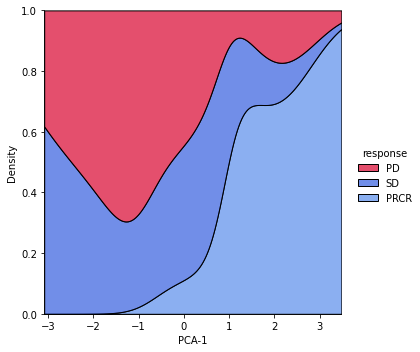

In [52]:
sns.displot(x='PCA-1',
            hue='response',
            data=pre_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

sns.displot(x='PCA-1',
            hue='response',
            data=on_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

In [53]:
on_91061_pca_coord['PCA-1'] = on_91061_pca_coord['PCA-1'].astype(float)
pre_91061_pca_coord['PCA-1'] = pre_91061_pca_coord['PCA-1'].astype(float)
fc_91061_pca_coord['PCA-1'] = fc_91061_pca_coord['PCA-1'].astype(float)

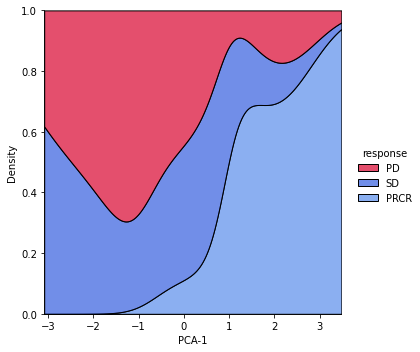

In [54]:
sns.displot(x='PCA-1',
            hue='response',
            data=on_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

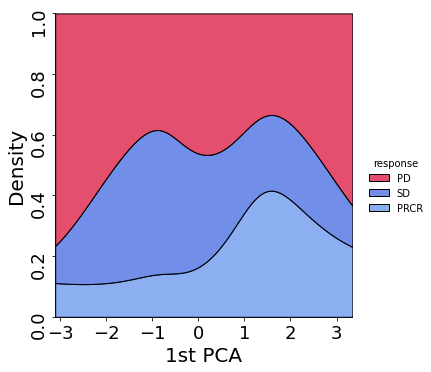

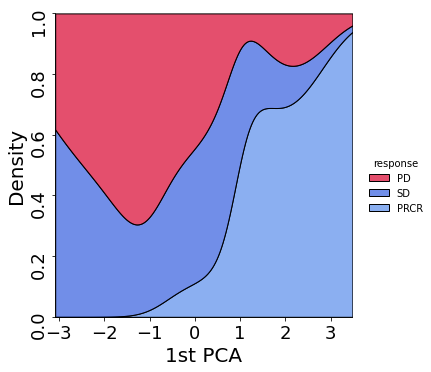

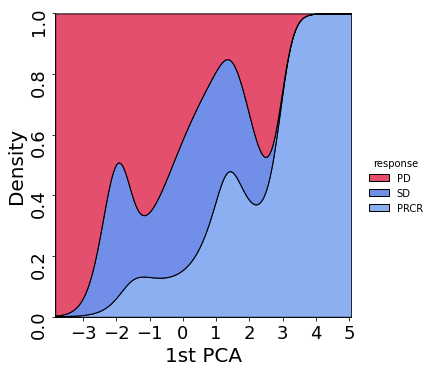

In [55]:
sns.displot(x='PCA-1',
            hue='response',
            data=pre_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)
# add labels
plt.xlabel('1st PCA', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.yticks(rotation=90, fontsize=18)
plt.xticks(rotation=0, fontsize=18)
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/pre_density_PCA1.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/pre_density_PCA1.png', dpi=300, transparent=True)

sns.displot(x='PCA-1',
            hue='response',
            data=on_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)
# add labels
plt.xlabel('1st PCA', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.yticks(rotation=90, fontsize=18)
plt.xticks(rotation=0, fontsize=18)
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/on_density_PCA1.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/on_density_PCA1.png', dpi=300, transparent=True)

sns.displot(x='PCA-1',
            hue='response',
            data=fc_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)
# add labels
plt.xlabel('1st PCA', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.yticks(rotation=90, fontsize=18)
plt.xticks(rotation=0, fontsize=18)
fig = plt.gcf()
fig.savefig(panel_home + 'PCA/ec_density_PCA1.pdf', transparent=True)
fig.savefig(panel_home + 'PCA/ec_density_PCA1.png', dpi=300, transparent=True)

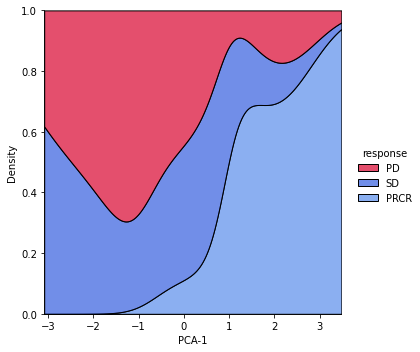

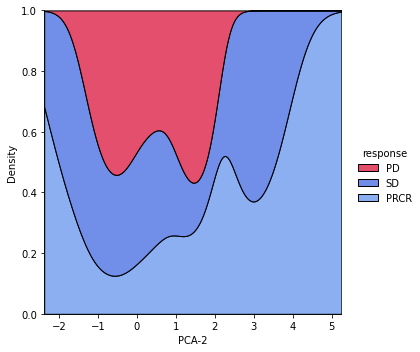

In [56]:
sns.displot(x='PCA-1',
            hue='response',
            data=on_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

sns.displot(x='PCA-2',
            hue='response',
            data=on_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

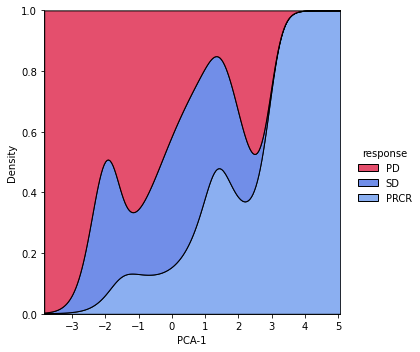

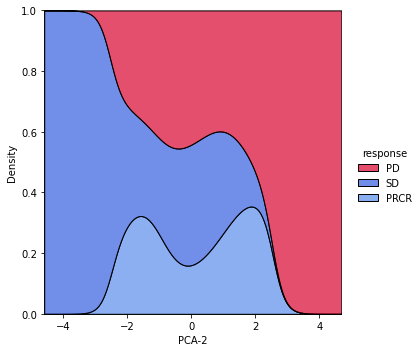

In [57]:
sns.displot(x='PCA-1',
            hue='response',
            data=fc_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

sns.displot(x='PCA-2',
            hue='response',
            data=fc_91061_pca_coord,
            kind='kde',
            multiple='fill',
            palette=response_lut)

## 1.3 NREC and REC profile establishment

In [58]:
deg_91061['fc']

,log2FC(P-N),ranksum_stat,ranksum_p,log10P
A2M,-0.108075,-0.787909,0.43075,0.365775
AAAS,0.26155,2.08415,0.0371468,1.430079
AACS,0.380061,2.92289,0.003468,2.459921
AAGAB,0.197753,1.82998,0.0672525,1.172292
AAMDC,0.0424936,0.609994,0.541866,0.266108
...,...,...,...,...
ZSCAN9,0.276723,1.04207,0.297378,0.526692
ZWILCH,0.454592,2.77039,0.00559891,2.251897
ZWINT,0.348637,1.57582,0.115068,0.939047
ZYX,-0.13168,-0.71166,0.476675,0.321777


In [59]:
deg_91061['fc'].loc['EZH2', :]

log2FC(P-N)     0.442407
ranksum_stat     1.88082
ranksum_p       0.059997
log10P           1.22187
Name: EZH2, dtype: object

In [60]:
sig_defc_91061 = deg_91061['fc'].sort_values(by='ranksum_p', ascending=True)[:1329] # p < 0.05

In [61]:
sig_defc_91061

,log2FC(P-N),ranksum_stat,ranksum_p,log10P
TYRO3,0.860045,4.29538,1.74397e-05,4.758461
TMCC2,0.777366,3.96496,7.34074e-05,4.134260
NDRG3,0.321298,3.93955,8.16358e-05,4.088119
ATP9A,0.933532,3.93955,8.16358e-05,4.088119
FGD1,0.603369,3.83788,0.000124101,3.906226
...,...,...,...,...
RFC1,0.319013,1.98248,0.0474254,1.323989
PAPD7,0.19303,1.98248,0.0474254,1.323989
BLNK,-0.677102,-1.98248,0.0474254,1.323989
MRPL15,0.235924,1.98248,0.0474254,1.323989


In [62]:
# establish sig_up and sig_down regarding to non-responders
sig_defc_91061_up = list(sig_defc_91061[sig_defc_91061['log2FC(P-N)'] > 0].index)
sig_defc_91061_down = list(sig_defc_91061[sig_defc_91061['log2FC(P-N)'] < 0].index)
print(len(sig_defc_91061_up), len(sig_defc_91061_down))

1190 139


In [63]:
# enrichment test: up
enrichr_defc_91061_up = gp.enrichr(gene_list=sig_defc_91061_up,
                                   gene_sets=['MSigDB_Hallmark_2020'],
                                   organism='Human',
                                   description='sig_defc_91061_up_0.05',
                                   outdir=gsea_home + 'NREC_REC_enrichment/sig_defc_91061_up_0.05',
                                   cutoff=0.5)

# enrichment test: down
enrichr_defc_91061_down = gp.enrichr(gene_list=sig_defc_91061_down,
                                   gene_sets=['MSigDB_Hallmark_2020'],
                                   organism='Human',
                                   description='sig_defc_91061_down_0.05',
                                   outdir=gsea_home + 'NREC_REC_enrichment/sig_defc_91061_down_0.05',
                                   cutoff=0.5)

In [64]:
enrichr_defc_91061_up.results.head(20)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Myc Targets V1,74/200,1.771959e-39,8.859793e-38,0,0,9.832565,877.347344,YWHAE;SLC25A3;HSP90AB1;MCM7;PWP1;PHB2;RRP9;CDC...
1,MSigDB_Hallmark_2020,E2F Targets,73/200,1.731679e-38,4.329199e-37,0,0,9.614187,835.945337,TOP2A;MCM7;DSCC1;CSE1L;BUB1B;HMGB3;BRCA1;IPO7;...
2,MSigDB_Hallmark_2020,G2-M Checkpoint,61/200,2.213764e-27,3.689607e-26,0,0,7.257527,445.431481,TOP2A;CCNT1;CCNF;HMGB3;CDC20;CHAF1A;PTTG1;EXO1...
3,MSigDB_Hallmark_2020,Myc Targets V2,30/58,6.988301e-22,8.735377e-21,0,0,17.347906,845.062224,NOLC1;TMEM97;PHB;WDR43;RRP9;TBRG4;HSPD1;UNG;TC...
4,MSigDB_Hallmark_2020,mTORC1 Signaling,51/200,2.787024e-19,2.787024e-18,0,0,5.607833,239.589869,GPI;PITPNB;CCNF;ATP2A2;TMEM97;ENO1;VLDLR;RRP9;...
5,MSigDB_Hallmark_2020,DNA Repair,34/150,9.550416e-12,7.958680e-11,0,0,4.739858,120.271226,POM121;FEN1;PCNA;CANT1;GTF3C5;USP11;AAAS;TYMS;...
6,MSigDB_Hallmark_2020,Mitotic Spindle,38/199,1.371941e-10,9.799581e-10,0,0,3.820857,86.770228,TOP2A;YWHAE;PXN;TTK;WASL;ARHGAP5;KLC1;AURKA;CC...
7,MSigDB_Hallmark_2020,Glycolysis,34/200,2.766348e-08,1.728967e-07,0,0,3.303331,57.488374,TSTA3;PYGB;PRPS1;ABCB6;ENO1;VLDLR;PYGL;PLOD1;A...
8,MSigDB_Hallmark_2020,Estrogen Response Early,30/200,2.735024e-06,1.367512e-05,0,0,2.835700,36.323529,CANT1;ENDOD1;ISG20L2;CELSR2;TMEM164;IGF1R;SYNG...
9,MSigDB_Hallmark_2020,Oxidative Phosphorylation,30/200,2.735024e-06,1.367512e-05,0,0,2.835700,36.323529,GPI;SLC25A3;OAT;MGST3;MRPL15;MRPS30;PHB2;TIMM5...


In [65]:
enrichr_defc_91061_down.results.head(20)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Allograft Rejection,20/200,9.587500e-18,3.643250e-16,0,0,18.376284,720.094373,GPR65;GZMA;NCF4;PRF1;CD3E;ITGAL;CD3D;PSMB10;CD...
1,MSigDB_Hallmark_2020,Interferon Gamma Response,15/200,9.712254e-12,1.845328e-10,0,0,12.865737,326.244626,CIITA;GCH1;C1S;GZMA;NMI;PSMB10;VAMP8;HLA-DMA;C...
2,MSigDB_Hallmark_2020,Complement,9/200,1.116645e-05,1.060813e-04,0,0,7.129682,81.296889,DPP4;CTSO;GCA;C1S;LCK;SPOCK2;GZMA;FDX1;LCP2
3,MSigDB_Hallmark_2020,Inflammatory Response,9/200,1.116645e-05,1.060813e-04,0,0,7.129682,81.296889,ABCA1;CD82;GCH1;LCK;IL2RB;LCP2;NMI;CXCR6;TNFRSF1B
4,MSigDB_Hallmark_2020,Apoptosis,8/161,1.708139e-05,1.298186e-04,0,0,7.866287,86.352336,CD2;CASP8;GCH1;DPYD;PRF1;CFLAR;BID;BIRC3
5,MSigDB_Hallmark_2020,Reactive Oxygen Species Pathway,4/49,3.713919e-04,2.352148e-03,0,0,13.047572,103.053023,HHEX;GLRX;LSP1;FTL
6,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,5.050197e-04,2.741535e-03,0,0,5.404145,41.022396,ABCA1;GCH1;CEBPD;ID2;CCL4;CFLAR;BIRC3
7,MSigDB_Hallmark_2020,Xenobiotic Metabolism,6/200,2.772993e-03,1.170819e-02,0,0,4.573366,26.927194,SLC46A3;GCH1;ID2;IRF8;FBP1;PSMB10
8,MSigDB_Hallmark_2020,KRAS Signaling Up,6/200,2.772993e-03,1.170819e-02,0,0,4.573366,26.927194,ID2;IRF8;GLRX;IKZF1;TNFRSF1B;BIRC3
9,MSigDB_Hallmark_2020,Interferon Alpha Response,4/97,4.699604e-03,1.717174e-02,0,0,6.298049,33.759285,CASP8;C1S;DHX58;NMI


In [66]:
# Nonresponder expression changing profiles
gene_NREC = sig_defc_91061_up

# Responder expression changing profiles
gene_REC = sig_defc_91061_down

In [67]:
# create gene sets
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'w') as f:
    tmp_up = ['NREC_profile', 'NRo-pVSRo-p']
    tmp_up.extend(gene_NREC)
    f.write('\t'.join(tmp_up))
    f.write('\n')
    tmp_down = ['REC_profile', 'NRo-pVSRo-p']
    tmp_down.extend(gene_REC)
    f.write('\t'.join(tmp_down))

In [68]:
# make pre-rank folders
if 'shRNA_all' not in os.listdir(gsea_home + '/SKCM/'):
    os.mkdir(gsea_home + '/SKCM/shRNA_all')

for p in skcm_trt_sh_original.columns:
    tmp = df(skcm_trt_sh_original[p]).sort_values(by=p, ascending=False)
    p_rename = '__'.join(p.split(':'))
    tmp.to_csv(gsea_home + '/SKCM/shRNA_all/' + p_rename + '.rnk', header=None, sep='\t')

In [69]:
# run pre-rank on all the shRNAs
prerank_shRNA_nes = df(index=['NREC_profile', 'REC_profile'], columns=skcm_trt_sh_original.columns)
prerank_shRNA_fdr = df(index=['NREC_profile', 'REC_profile'], columns=skcm_trt_sh_original.columns)
prerank_shRNA_es = df(index=['NREC_profile', 'REC_profile'], columns=skcm_trt_sh_original.columns)

for p in skcm_trt_sh_original.columns:
    p_rename = '__'.join(p.split(':'))
    rnk = pd.read_csv(gsea_home + '/SKCM/shRNA_all/' + p_rename + '.rnk', header=None, sep="\t")
    pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                         processes=1,
                         permutation_num=500, # reduce number to speed up testing
                         outdir=None, format='png', seed=0, min_size=0, max_size=10000)
    prerank_shRNA_nes[p] = pre_res.res2d['nes']
    prerank_shRNA_fdr[p] = pre_res.res2d['fdr']
    prerank_shRNA_es[p] = pre_res.res2d['es']

KeyboardInterrupt: 

In [ ]:
prerank_shRNA_fdr_result = prerank_shRNA_fdr.T.copy()
prerank_shRNA_fdr_result['cmap_name'] = skcm_sig_info['cmap_name']
prerank_shRNA_fdr_result = prerank_shRNA_fdr_result.sort_values(by='NREC_profile', ascending=True)

prerank_shRNA_es_result = prerank_shRNA_es.T.copy()
prerank_shRNA_es_result['cmap_name'] = skcm_sig_info['cmap_name']
prerank_shRNA_es_result = prerank_shRNA_es_result.sort_values(by='NREC_profile', ascending=True)

prerank_shRNA_nes_result = prerank_shRNA_nes.T.copy()
prerank_shRNA_nes_result['cmap_name'] = skcm_sig_info['cmap_name']
prerank_shRNA_nes_result = prerank_shRNA_nes_result.sort_values(by='NREC_profile', ascending=True)

prerank_shRNA_es_result.to_csv(gsea_home + 'SKCM/shRNA_all_results/es_sorted_by_NREC.csv', sep=',')
prerank_shRNA_nes_result.to_csv(gsea_home + 'SKCM/shRNA_all_results/nes_sorted_by_NREC.csv', sep=',')
prerank_shRNA_fdr_result.to_csv(gsea_home + 'SKCM/shRNA_all_results/fdr_sorted_by_NREC.csv', sep=',')

In [ ]:
# visualize by scatter plot: how shRNA perturbation shift the transcriptome profiles from non-responder to responder
plt.figure(figsize=(6, 6))
sns.scatterplot(x='NREC_profile',
                y='REC_profile',
                data=prerank_shRNA_es_result)
plt.axvline(x=0., c='k')
plt.axhline(y=0., c='k')

## 1.5 shRNAs that targeting the NREC profiles

In [70]:
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    gene_NREC = f.readline().split('\t')[2:]
    gene_REC = f.readline().split('\t')[2:]

In [44]:
len(gene_NREC)

1190

In [71]:
shRNA_skcm_target = list(skcm_sig_info.loc[skcm_trt_sh_original.columns, 'cmap_name'].unique())
print(len(shRNA_skcm_target))

shRNA_NREC_target = list(set(shRNA_skcm_target) & set(gene_NREC))
print(len(shRNA_NREC_target))

shRNA_REC_target = list(set(shRNA_skcm_target) & set(gene_REC))
print(len(shRNA_REC_target))

1556
213
23


In [72]:
prerank_shRNA_es_result = pd.read_csv(gsea_home + 'SKCM/shRNA_all_results/es_sorted_by_NREC.csv', header=0, index_col=0, sep=',')

In [73]:
shRNA_NREC_es = prerank_shRNA_es_result[prerank_shRNA_es_result['cmap_name'].isin(shRNA_NREC_target)]

In [74]:
shRNA_REC_es = prerank_shRNA_es_result[prerank_shRNA_es_result['cmap_name'].isin(shRNA_REC_target)]

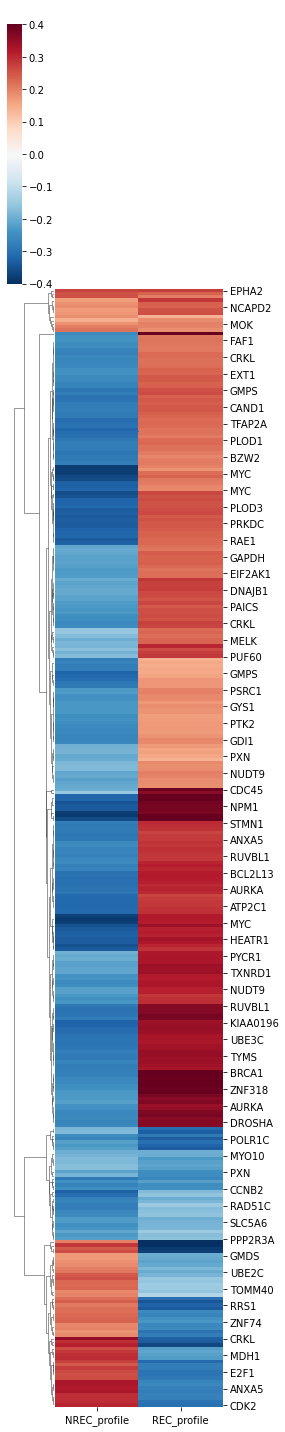

In [75]:
sns.clustermap(shRNA_NREC_es[['NREC_profile', 'REC_profile']].rename(index=skcm_sig_info['cmap_name']),
               figsize=(4, 20),
               cmap='RdBu_r', vmax=.4, vmin=-.4,
               col_cluster=False, row_cluster=True)
plt.show()

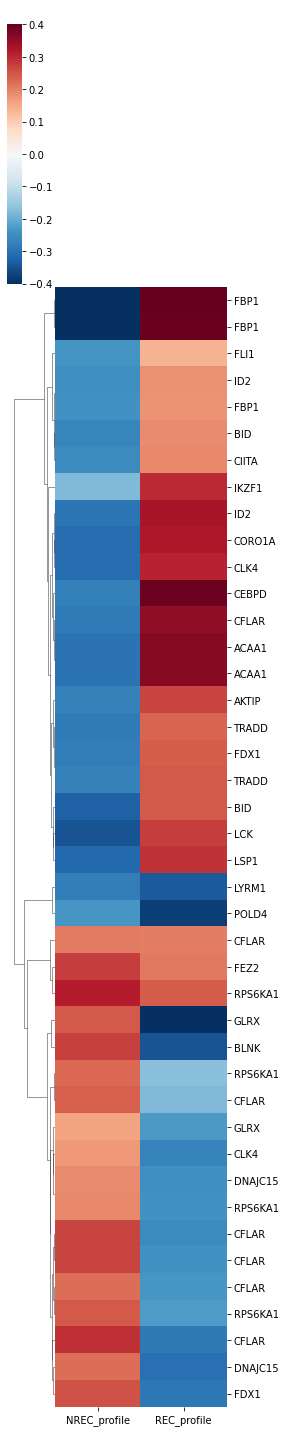

In [76]:
sns.clustermap(shRNA_REC_es[['NREC_profile', 'REC_profile']].rename(index=skcm_sig_info['cmap_name']),
               figsize=(4, 20),
               cmap='RdBu_r', vmax=.4, vmin=-.4,
               col_cluster=False, row_cluster=True)
plt.show()

In [77]:
shRNA_NREC_es_pivot = df(columns=['es', 'profile', 'sig'])
for sig in shRNA_NREC_es.index:
    shRNA_NREC_es_pivot.at[sig + '_1', 'es'] = shRNA_NREC_es.loc[sig, 'NREC_profile']
    shRNA_NREC_es_pivot.at[sig + '_1', 'profile'] = 'NREC_profile'
    shRNA_NREC_es_pivot.at[sig + '_1', 'sig'] = sig
    
    shRNA_NREC_es_pivot.at[sig + '_2', 'es'] = shRNA_NREC_es.loc[sig, 'REC_profile']
    shRNA_NREC_es_pivot.at[sig + '_2', 'profile'] = 'REC_profile'
    shRNA_NREC_es_pivot.at[sig + '_2', 'sig'] = sig

In [78]:
shRNA_REC_es_pivot = df(columns=['es', 'profile', 'sig'])
for sig in shRNA_REC_es.index:
    shRNA_REC_es_pivot.at[sig + '_1', 'es'] = shRNA_REC_es.loc[sig, 'NREC_profile']
    shRNA_REC_es_pivot.at[sig + '_1', 'profile'] = 'NREC_profile'
    shRNA_REC_es_pivot.at[sig + '_1', 'sig'] = sig
    
    shRNA_REC_es_pivot.at[sig + '_2', 'es'] = shRNA_REC_es.loc[sig, 'REC_profile']
    shRNA_REC_es_pivot.at[sig + '_2', 'profile'] = 'REC_profile'
    shRNA_REC_es_pivot.at[sig + '_2', 'sig'] = sig

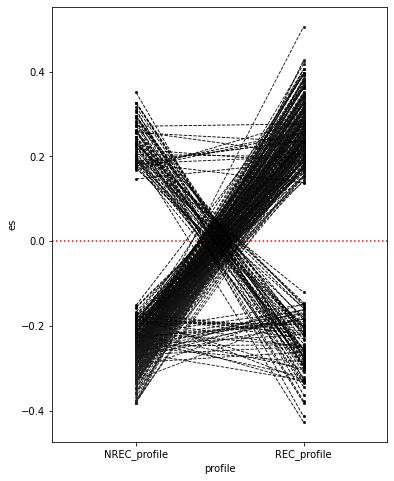

In [211]:
plt.figure(figsize=(6, 8))
with plt.rc_context({'lines.linewidth': 0.5}):
    g = sns.pointplot(x='profile',
                      y='es',
                      hue='sig',
                      data=shRNA_NREC_es_pivot,
                      linestyles='--',
                      color='k')
g.legend().remove()
plt.axhline(y=0., c='r', ls=':')

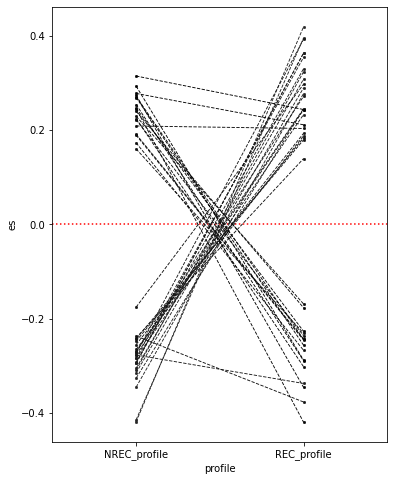

In [212]:
plt.figure(figsize=(6, 8))
with plt.rc_context({'lines.linewidth': 0.5}):
    g = sns.pointplot(x='profile',
                      y='es',
                      hue='sig',
                      data=shRNA_REC_es_pivot,
                      linestyles='--',
                      color='k')
g.legend().remove()
plt.axhline(y=0., c='r', ls=':')

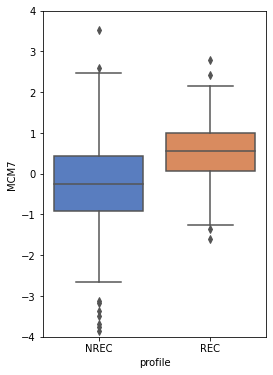

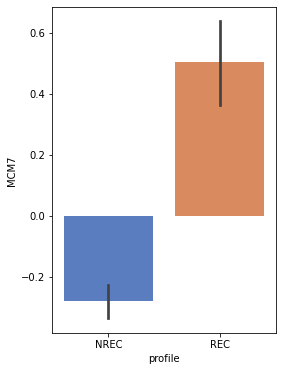

In [243]:
# try box plot for individual genes
test1 = df(skcm_trt_sh_original['KDC003_A375_96H:TRCN0000019719:-666']).rename(columns={'KDC003_A375_96H:TRCN0000019719:-666': 'MCM7'})
test1.at[gene_NREC, 'profile'] = 'NREC'
test1.at[gene_REC, 'profile'] = 'REC'
test1 = test1.dropna(axis=0, how='any')

plt.figure(figsize=(4, 6))
sns.boxplot(x='profile', y='MCM7', data=test1, palette='muted')
plt.ylim(-4, 4)
plt.show()


plt.figure(figsize=(4, 6))
sns.barplot(x='profile', y='MCM7', data=test1, palette='muted')
plt.show()


## 1.6 Genes in the NREC and REC profiles

In [79]:
NREC_fc = log2exp2_91061_top_fc[log2exp2_91061_top_fc.index.isin(gene_NREC)]
REC_fc = log2exp2_91061_top_fc[log2exp2_91061_top_fc.index.isin(gene_REC)]

In [80]:
NREC_fc

,Pt1,Pt2,Pt23,Pt82,Pt49,Pt85,Pt89,Pt101,Pt47,Pt52,...,Pt27,Pt30,Pt31,Pt8,Pt11,Pt26,Pt28,Pt44,Pt106,Pt34
AAAS,0.192613,-0.149031,0.363193,-0.204538,0.079780,0.709740,0.002913,0.080311,0.417891,0.494142,...,-0.050799,-1.393336,0.356501,0.258082,0.119867,-0.061024,0.053801,-0.784468,0.028667,0.097267
AACS,0.560994,-0.163852,-0.089526,-0.656831,-0.411034,0.058663,-0.398231,0.143135,0.202002,0.447684,...,0.282316,-0.347635,-0.051887,-0.194255,-0.159741,0.114804,0.080494,0.035747,0.160373,-0.434511
AAR2,-0.208168,0.057618,0.290401,-0.304253,-0.031578,-0.024094,-0.005799,-0.044199,0.143401,0.082163,...,-0.136163,-0.253680,-0.050470,0.484996,-0.210584,-0.154973,0.717670,-0.337013,0.087291,-0.067881
ABCB6,0.852308,-0.131008,0.596724,-0.632622,-0.420540,0.502809,-0.161204,0.257780,0.447615,0.088316,...,0.126761,-2.882500,-0.138218,-0.281142,-0.039699,0.086972,-0.081876,-0.873874,-0.205933,0.021812
ABCF1,0.292262,0.043080,0.096022,-0.255913,-0.034180,0.379245,-0.025275,0.258063,0.155022,0.166759,...,0.200048,-1.731351,0.109969,-0.150702,0.164950,-0.019260,0.220131,-0.820953,-0.113816,-0.440396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF609,0.305678,-0.159387,0.129125,0.096756,0.238986,0.269441,-0.160213,0.193140,-0.024297,0.447812,...,0.421750,-0.341479,0.093782,-0.278417,-0.034606,0.084664,0.089571,-0.348433,-0.356353,-0.610850
ZNF623,0.122546,-0.097236,-0.045131,-0.692421,-0.060510,0.194441,-0.675412,0.193901,-0.024915,0.161483,...,-0.028809,-2.457290,-0.026028,-0.263652,-0.426240,0.006440,0.877279,-0.786288,-0.386687,-0.447692
ZNF74,0.304376,0.173621,0.111843,-0.432522,0.007203,0.372024,-0.231047,-0.191008,-0.001715,0.349615,...,0.423527,-2.568789,-0.573468,0.122112,-0.188492,-0.077470,0.238009,-1.242003,-0.102960,0.147356
ZNF768,0.124760,0.048429,0.705049,-0.052607,-0.150928,0.025273,-0.229820,-0.229089,0.031529,0.240708,...,0.141471,-1.626075,-0.611260,0.009254,-0.151875,0.090587,0.507063,-0.773799,0.184202,0.138213


In [81]:
REC_fc

,Pt1,Pt2,Pt23,Pt82,Pt49,Pt85,Pt89,Pt101,Pt47,Pt52,...,Pt27,Pt30,Pt31,Pt8,Pt11,Pt26,Pt28,Pt44,Pt106,Pt34
ABCA1,-0.698591,-0.082257,-1.683722,0.181489,0.112445,0.126190,-0.385362,0.502002,-0.115257,-0.250963,...,0.421424,2.572222,-0.145280,-0.786104,0.139661,0.403136,-0.496413,0.479689,-1.169597,0.669711
ACAA1,-0.256611,-0.505593,-0.062936,1.881139,0.335789,-0.114088,0.083782,-0.182284,0.062034,-1.273026,...,0.375716,0.542606,0.497734,-0.004238,0.224046,-0.125184,-0.136858,0.002678,-0.033333,0.205443
ACAP1,-0.871167,-0.463258,0.470151,1.075938,0.997465,1.024086,0.119598,0.073757,-0.449152,0.336670,...,0.193757,3.523351,0.497991,-1.035126,0.048812,-0.277007,1.960420,0.315753,-0.122139,0.831967
ACYP2,-0.403316,0.079173,-0.207405,0.556433,-0.414789,-0.324083,0.069448,-0.299930,0.066422,0.045689,...,-0.576565,0.265073,-0.760330,-0.366549,0.394580,0.169452,-0.808960,-0.130829,0.100570,0.060038
ADAM28,-1.224749,-0.312033,-0.696157,-0.240162,1.017323,0.191065,0.235169,-0.190657,0.071202,0.501920,...,0.175796,2.916475,0.637176,-0.632035,0.017499,-0.314816,1.328214,-0.168535,-0.531525,0.211734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRIM22,-1.721596,-0.436406,-0.926260,0.692870,0.697689,-0.247610,0.085641,-0.159088,-0.423916,0.045972,...,0.000553,3.703707,0.638232,0.026706,0.080320,0.302530,1.458893,0.256915,-0.358351,0.311498
TUBA4A,-1.076457,-0.510587,0.638103,1.012293,1.137094,0.564100,-1.978601,-0.194457,0.782314,-0.445567,...,-1.079933,1.497997,0.247710,-0.814320,-0.459570,-0.121736,1.275265,0.440086,-0.114317,-0.028299
VAMP8,-0.888100,-0.236278,-0.634836,-0.029147,0.608407,-0.051817,0.401525,-0.373694,0.135151,-0.058447,...,-0.097877,2.297172,1.318158,0.579928,0.321281,-0.052375,-0.074071,-0.347651,0.422371,0.151440
VAV1,-1.301850,-0.512090,-0.326092,0.515838,0.547329,0.389305,1.005126,0.045275,-0.466835,0.008948,...,0.001212,3.992769,1.387311,-0.432804,0.148791,-0.456548,1.719081,0.139535,-0.221838,0.429144


In [82]:
merged_profile_fc = pd.concat([NREC_fc, REC_fc], axis=0)
merged_profile_fc

,Pt1,Pt2,Pt23,Pt82,Pt49,Pt85,Pt89,Pt101,Pt47,Pt52,...,Pt27,Pt30,Pt31,Pt8,Pt11,Pt26,Pt28,Pt44,Pt106,Pt34
AAAS,0.192613,-0.149031,0.363193,-0.204538,0.079780,0.709740,0.002913,0.080311,0.417891,0.494142,...,-0.050799,-1.393336,0.356501,0.258082,0.119867,-0.061024,0.053801,-0.784468,0.028667,0.097267
AACS,0.560994,-0.163852,-0.089526,-0.656831,-0.411034,0.058663,-0.398231,0.143135,0.202002,0.447684,...,0.282316,-0.347635,-0.051887,-0.194255,-0.159741,0.114804,0.080494,0.035747,0.160373,-0.434511
AAR2,-0.208168,0.057618,0.290401,-0.304253,-0.031578,-0.024094,-0.005799,-0.044199,0.143401,0.082163,...,-0.136163,-0.253680,-0.050470,0.484996,-0.210584,-0.154973,0.717670,-0.337013,0.087291,-0.067881
ABCB6,0.852308,-0.131008,0.596724,-0.632622,-0.420540,0.502809,-0.161204,0.257780,0.447615,0.088316,...,0.126761,-2.882500,-0.138218,-0.281142,-0.039699,0.086972,-0.081876,-0.873874,-0.205933,0.021812
ABCF1,0.292262,0.043080,0.096022,-0.255913,-0.034180,0.379245,-0.025275,0.258063,0.155022,0.166759,...,0.200048,-1.731351,0.109969,-0.150702,0.164950,-0.019260,0.220131,-0.820953,-0.113816,-0.440396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRIM22,-1.721596,-0.436406,-0.926260,0.692870,0.697689,-0.247610,0.085641,-0.159088,-0.423916,0.045972,...,0.000553,3.703707,0.638232,0.026706,0.080320,0.302530,1.458893,0.256915,-0.358351,0.311498
TUBA4A,-1.076457,-0.510587,0.638103,1.012293,1.137094,0.564100,-1.978601,-0.194457,0.782314,-0.445567,...,-1.079933,1.497997,0.247710,-0.814320,-0.459570,-0.121736,1.275265,0.440086,-0.114317,-0.028299
VAMP8,-0.888100,-0.236278,-0.634836,-0.029147,0.608407,-0.051817,0.401525,-0.373694,0.135151,-0.058447,...,-0.097877,2.297172,1.318158,0.579928,0.321281,-0.052375,-0.074071,-0.347651,0.422371,0.151440
VAV1,-1.301850,-0.512090,-0.326092,0.515838,0.547329,0.389305,1.005126,0.045275,-0.466835,0.008948,...,0.001212,3.992769,1.387311,-0.432804,0.148791,-0.456548,1.719081,0.139535,-0.221838,0.429144


/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


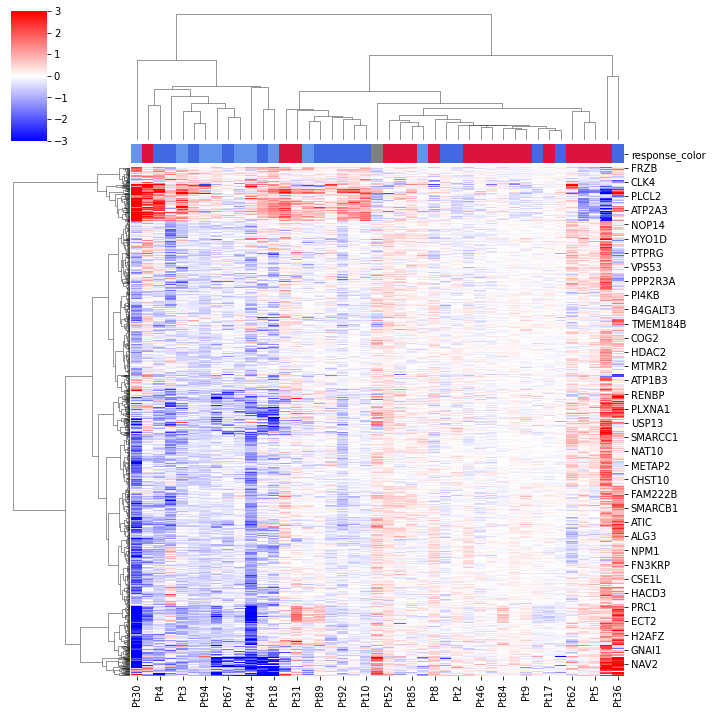

In [83]:
sns.clustermap(merged_profile_fc,
               figsize=(10, 10),
               cmap='bwr',
               z_score=None,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=paired_91061['response_color'])

In [87]:
# in Pre treatment
NREC_pre = log2exp2_91061[log2exp2_91061.index.isin(gene_NREC)][paired_91061['Pre']]
REC_pre = log2exp2_91061[log2exp2_91061.index.isin(gene_REC)][paired_91061['Pre']]

In [88]:
merged_profile_pre = pd.concat([NREC_pre, REC_pre], axis=0)
merged_profile_pre

,Pt1_Pre_AD101148-6,Pt2_Pre_AD101150-6,Pt23_Pre_AD313075-5,Pt82_Pre_AD823914-8,Pt49_Pre_AD667851-6,Pt85_Pre_AD486329-5,Pt89_Pre_AE070951-5,Pt101_Pre_AD486328-5,Pt47_Pre_AD506073-6,Pt52_Pre_AD506075-6,...,Pt27_Pre_AD453873-5,Pt30_Pre_AD497503-5,Pt31_Pre_AD453872-5,Pt8_Pre_AD153354-6,Pt11_Pre_AD153352-6,Pt26_Pre_AD467789-6,Pt28_Pre_AD297619-6,Pt44_Pre_AD467790-6,Pt106_Pre_AD502250-5,Pt34_Pre_AD466985-6
AAAS,4.260058,4.522722,4.632275,4.326947,4.136908,3.587504,4.503216,4.528312,4.341942,4.002840,...,5.049554,5.157517,4.008222,4.655492,4.185053,4.867346,4.471004,4.475107,4.848491,3.922979
AACS,2.966406,3.160712,3.061225,2.311646,2.567303,2.344247,3.549245,2.352609,2.384209,2.596992,...,3.465808,2.263286,2.452170,3.015338,3.525292,2.325825,1.933418,2.580465,2.135520,2.324736
AAR2,4.161361,4.206427,4.353767,4.579190,4.534930,4.841919,4.505717,4.325926,4.136390,4.305562,...,4.260432,4.086115,4.642371,5.104977,4.305354,4.504923,4.184286,4.402010,4.467936,4.015225
ABCB6,2.674268,2.582438,3.142614,3.725251,2.532203,1.704687,2.465732,1.540689,2.252071,3.061944,...,2.772476,4.338377,2.212192,2.146861,2.287790,2.312517,3.264056,2.552560,3.394591,1.221795
ABCF1,1.953081,2.918953,2.037698,3.221754,2.110752,2.037958,2.403723,1.995272,2.444627,1.785799,...,1.745089,3.743735,2.793563,3.399384,2.220767,2.583966,2.636713,2.582339,2.949071,2.177478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRIM22,4.383473,5.022501,4.851315,3.848729,5.315105,5.528875,3.906541,6.699048,4.773425,4.308290,...,3.390250,2.206024,5.375024,4.679021,5.320981,5.359370,3.320633,4.579101,4.611331,4.534168
TUBA4A,2.587171,2.462943,2.696775,2.100235,3.586578,0.793135,5.219311,5.815542,2.215999,2.258272,...,3.342591,1.957214,2.772996,2.206812,5.473066,0.696930,1.976686,1.944017,1.604080,2.894992
VAMP8,7.373734,6.379740,6.688382,6.509841,7.191671,4.278806,7.179395,7.652055,7.242334,5.906244,...,6.476972,5.643545,5.682470,6.275340,7.757718,6.321279,6.739343,5.942887,6.329465,7.959288
VAV1,3.285270,3.385329,3.236937,2.405742,3.966159,0.972052,1.483283,5.433059,2.825156,1.913901,...,2.685160,1.210587,2.470703,2.868705,2.849656,1.182831,1.875461,2.725978,2.582964,4.479596


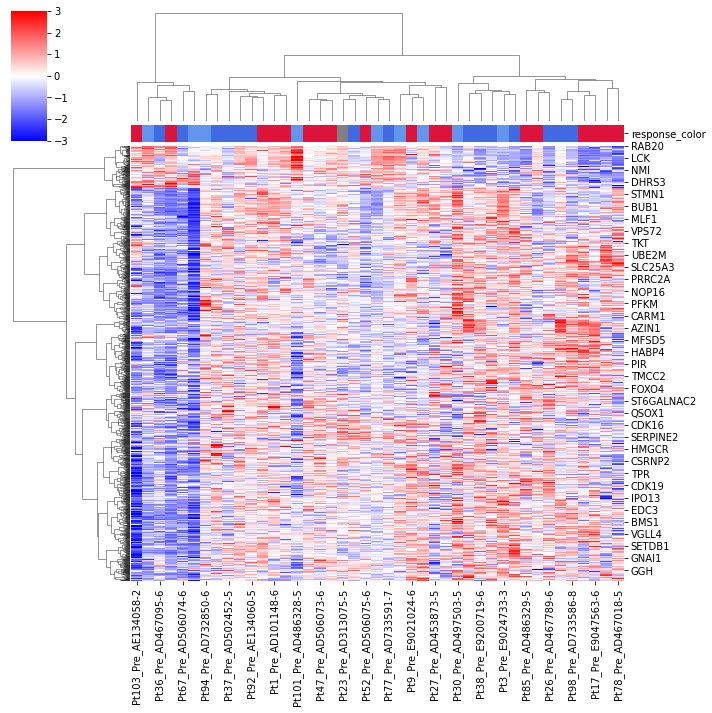

In [97]:
sns.clustermap(merged_profile_pre,
               figsize=(10, 10),
               cmap='bwr',
               z_score=0,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=paired_91061.set_index('Pre')['response_color'])

In [ ]:
merged_profile_fc_ave = df(index=merged_profile_fc.index, columns=['ave_fc_NR', 'ave_fc_R'])
merged_profile_fc_ave['ave_fc_NR'] = merged_profile_fc[tmp_fc_NR].mean(axis=1)
merged_profile_fc_ave['ave_fc_R'] = merged_profile_fc[tmp_fc_R].mean(axis=1)
merged_profile_fc_ave['profile'] = 'NREC'
merged_profile_fc_ave.at[gene_REC, 'profile'] = 'REC'

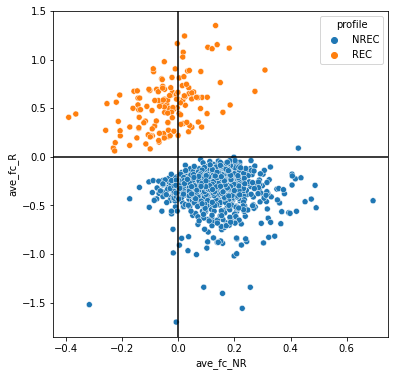

In [48]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='ave_fc_NR', y='ave_fc_R', hue='profile', data=merged_profile_fc_ave)
plt.axvline(x=0., c='k')
plt.axhline(y=0., c='k')

In [53]:
for g in gene_NREC:
    if merged_profile_fc_ave.loc[g, 'ave_fc_NR'] < 0 and merged_profile_fc_ave.loc[g, 'ave_fc_R'] <= 0:
        merged_profile_fc_ave.at[g, 'profile_direction'] = 'NR-|R-'
    elif merged_profile_fc_ave.loc[g, 'ave_fc_NR'] > 0 and merged_profile_fc_ave.loc[g, 'ave_fc_R'] <= 0:
        merged_profile_fc_ave.at[g, 'profile_direction'] = 'NR+|R-'
    elif merged_profile_fc_ave.loc[g, 'ave_fc_NR'] > 0 and merged_profile_fc_ave.loc[g, 'ave_fc_R'] > 0:
        merged_profile_fc_ave.at[g, 'profile_direction'] = 'NR+|R+'

for g in gene_REC:
    if merged_profile_fc_ave.loc[g, 'ave_fc_NR'] >= 0 and merged_profile_fc_ave.loc[g, 'ave_fc_R'] > 0:
        merged_profile_fc_ave.at[g, 'profile_direction'] = 'R+|NR+'
    elif merged_profile_fc_ave.loc[g, 'ave_fc_NR'] < 0 and merged_profile_fc_ave.loc[g, 'ave_fc_R'] > 0:
        merged_profile_fc_ave.at[g, 'profile_direction'] = 'R+|NR-'
    elif merged_profile_fc_ave.loc[g, 'ave_fc_NR'] < 0 and merged_profile_fc_ave.loc[g, 'ave_fc_R'] < 0:
        merged_profile_fc_ave.at[g, 'profile_direction'] = 'R-|NR-'

In [56]:
merged_profile_fc_ave['profile_direction'].value_counts()

NR+|R-    1101
R+|NR-      93
NR-|R-      88
R+|NR+      46
NR+|R+       1
Name: profile_direction, dtype: int64

In [85]:
merged_profile_fc_ave.loc[shRNA_NREC_es[shRNA_NREC_es['NREC_profile'] > 0]['cmap_name'].unique(), 'profile_direction'].value_counts()

NR+|R-    50
NR-|R-     2
Name: profile_direction, dtype: int64

In [86]:
merged_profile_fc_ave.loc[shRNA_NREC_es[shRNA_NREC_es['NREC_profile'] < 0]['cmap_name'].unique(), 'profile_direction'].value_counts()

NR+|R-    173
NR-|R-      7
Name: profile_direction, dtype: int64

In [69]:
merged_profile_fc_ave.loc[shRNA_REC_es[shRNA_REC_es['REC_profile'] > 0]['cmap_name'].unique(), 'profile_direction'].value_counts()

R+|NR-    13
R+|NR+     5
Name: profile_direction, dtype: int64

In [87]:
merged_profile_fc_ave.loc[shRNA_REC_es[shRNA_REC_es['REC_profile'] < 0]['cmap_name'].unique(), 'profile_direction'].value_counts()

R+|NR-    7
R+|NR+    2
Name: profile_direction, dtype: int64

# 2. shRNAs that can affect NREC and REC (not direct targeting)

In [50]:
prerank_shRNA_es_result

,NREC_profile,REC_profile,cmap_name
KDA002_A375_96H:H10,-0.418181,0.418882,FBP1
KDA002_A375_96H:TRCN0000050034:-666,-0.413904,0.395217,FBP1
KDC004_A375_96H:TRCN0000007400:-666,-0.406783,0.349941,ARHGEF6
KDB001_A375_96H:TRCN0000153171:-666,-0.404539,0.231638,TSPAN6
KDB004_A375_96H:TRCN0000082833:-666,-0.401795,0.347834,COL4A5
...,...,...,...
KDD006_A375_96H:TRCN0000006382:-666,0.351001,-0.327021,CRKL
KDB002_A375_96H:TRCN0000183104:-666,0.354830,-0.221236,ZNF395
TAK003_A375_96H:TRCN0000019413:-666,0.371441,-0.211632,STAT6
KDD001_A375_96H:TRCN0000195313:-666,0.374614,-0.397508,MYLK2


In [51]:
# calculate the shift ability: NREC - REC
shift_shRNA = df(prerank_shRNA_es_result['NREC_profile'] - prerank_shRNA_es_result['REC_profile']).rename(columns={0: 'shift_ability'})
shift_shRNA['cmap_name'] = prerank_shRNA_es_result['cmap_name']
shift_shRNA['NREC_es'] = prerank_shRNA_es_result['NREC_profile']
shift_shRNA['REC_es'] = prerank_shRNA_es_result['REC_profile']

In [52]:
shift_shRNA

,shift_ability,cmap_name,NREC_es,REC_es
KDA002_A375_96H:H10,-0.837063,FBP1,-0.418181,0.418882
KDA002_A375_96H:TRCN0000050034:-666,-0.809121,FBP1,-0.413904,0.395217
KDC004_A375_96H:TRCN0000007400:-666,-0.756723,ARHGEF6,-0.406783,0.349941
KDB001_A375_96H:TRCN0000153171:-666,-0.636177,TSPAN6,-0.404539,0.231638
KDB004_A375_96H:TRCN0000082833:-666,-0.749630,COL4A5,-0.401795,0.347834
...,...,...,...,...
KDD006_A375_96H:TRCN0000006382:-666,0.678023,CRKL,0.351001,-0.327021
KDB002_A375_96H:TRCN0000183104:-666,0.576066,ZNF395,0.354830,-0.221236
TAK003_A375_96H:TRCN0000019413:-666,0.583072,STAT6,0.371441,-0.211632
KDD001_A375_96H:TRCN0000195313:-666,0.772121,MYLK2,0.374614,-0.397508


In [57]:
shift_shRNA_top = shift_shRNA[shift_shRNA['shift_ability'] < -0.6]
shift_shRNA_top.shape

(429, 4)

In [62]:
shift_shRNA_top['cmap_name'].value_counts()[:50]

CALR        4
JUN         4
MCM3        3
CRKL        3
RAF1        3
BLVRA       3
ME2         3
TGFBR2      3
ERBB3       2
PLK2        2
GATA3       2
TYMS        2
IRS1        2
AKR1A1      2
BRCA1       2
IDH3B       2
WDR61       2
STK33       2
RRP12       2
MAP4K3      2
ORMDL3      2
ATG7        2
DROSHA      2
F3          2
LHX2        2
GFPT1       2
ABAT        2
RIPK3       2
TCEB3       2
NR2C1       2
NR2C2       2
JAG1        2
FOXO4       2
PIK3C2B     2
MAD2L1BP    2
ACAA1       2
RIT1        2
AKAP11      2
PTPN1       2
MAP2K6      2
NOLC1       2
NPM1        2
NKX2-3      2
FBP1        2
RARA        2
STK38       2
HS2ST1      2
PAX8        2
AES         2
HRAS        2
Name: cmap_name, dtype: int64

<AxesSubplot:xlabel='shift_ability', ylabel='NREC_es'>

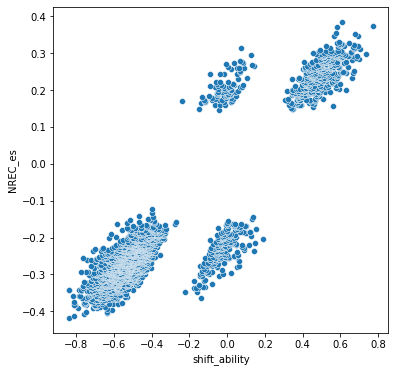

In [53]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='NREC_es', data=shift_shRNA)

In [93]:
shift_shRNA[shift_shRNA['cmap_name'] == 'EZH2']

,shift_ability,cmap_name,NREC_es,REC_es
KDB006_A375_96H:TRCN0000040075:-666,-0.568979,EZH2,-0.320012,0.248967
KDB006_A375_96H:TRCN0000010474:-666,-0.564069,EZH2,-0.299254,0.264814


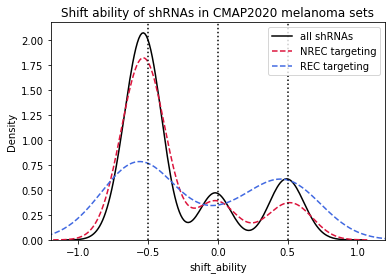

In [49]:
# show the distribution of the shiftability
plt.figure(figsize=(6, 4))
sns.kdeplot(x='shift_ability', data=shift_shRNA, label='all shRNAs', c='k')
sns.kdeplot(x='shift_ability', data=shift_shRNA[shift_shRNA['cmap_name'].isin(gene_NREC)], label='NREC targeting', c='crimson', ls='--')
sns.kdeplot(x='shift_ability', data=shift_shRNA[shift_shRNA['cmap_name'].isin(gene_REC)], label='REC targeting', c='royalblue', ls='--')
plt.title('Shift ability of shRNAs in CMAP2020 melanoma sets')
plt.axvline(x=-.5, ls=':', c='k')
plt.axvline(x=.5, ls=':', c='k')
plt.axvline(x=0, ls=':', c='k')
plt.xlim(-1.2, 1.2)
plt.legend()

In [ ]:
# shift ability < 0 means inhibition will lead to the shift towards REC profile
# shift ability > 0 means inhibition will lead to the shift towards NREC profile
# further cutoff will be set to get the top hits: -0.5 and 0.5

In [14]:
top_shift_REC = shift_shRNA[shift_shRNA['shift_ability'] <= -.5]
top_shift_NREC = shift_shRNA[shift_shRNA['shift_ability'] > .5]

In [15]:
# number of top hits on both side
print(len(top_shift_REC['cmap_name'].unique()))
print(len(top_shift_NREC['cmap_name'].unique()))

793
182


In [18]:
# overlap between top REC-shifting and top-NREC shifting
op_top_shift = list(set(list(top_shift_REC['cmap_name'].unique())) & set(list(top_shift_NREC['cmap_name'].unique())))

In [19]:
op_top_shift

['JUN',
 'DCK',
 'NDUFS6',
 'TNIP1',
 'KRAS',
 'MAP3K8',
 'VDAC1',
 'CFLAR',
 'PPAP2A',
 'PPARA',
 'RAD9A',
 'HOXA5',
 'SAP18',
 'NBN',
 'RNF123',
 'SGK3',
 'PABPC1',
 'STAT6',
 'FDX1',
 'PLOD3',
 'ANXA5',
 'SFN',
 'PARP2',
 'AKT2',
 'CRKL',
 'MEF2BNB-MEF2B',
 'PCDH15',
 'DAPK3',
 'TCFL5',
 'PTGER4',
 'UBE2C',
 'BAD',
 'HIST1H1B']

In [39]:
len(op_top_shift)

33

In [47]:
len(list(set(op_top_shift) & set(gene_NREC)))

6

In [48]:
len(list(set(op_top_shift) & set(gene_REC)))

2

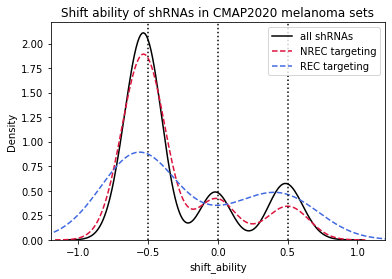

In [53]:
# show the distribution of the shiftability: exclude the overlap genes
tmp_NREC_targeting = shift_shRNA[shift_shRNA['cmap_name'].isin(gene_NREC)]
tmp_NREC_targeting = tmp_NREC_targeting[~tmp_NREC_targeting['cmap_name'].isin(op_top_shift)]

tmp_REC_targeting = shift_shRNA[shift_shRNA['cmap_name'].isin(gene_REC)]
tmp_REC_targeting = tmp_REC_targeting[~tmp_REC_targeting['cmap_name'].isin(op_top_shift)]

plt.figure(figsize=(6, 4))
sns.kdeplot(x='shift_ability', data=shift_shRNA[~shift_shRNA['cmap_name'].isin(op_top_shift)], label='all shRNAs', c='k')
sns.kdeplot(x='shift_ability', data=tmp_NREC_targeting, label='NREC targeting', c='crimson', ls='--')
sns.kdeplot(x='shift_ability', data=tmp_REC_targeting, label='REC targeting', c='royalblue', ls='--')
plt.title('Shift ability of shRNAs in CMAP2020 melanoma sets')
plt.axvline(x=-.5, ls=':', c='k')
plt.axvline(x=.5, ls=':', c='k')
plt.axvline(x=0, ls=':', c='k')
plt.xlim(-1.2, 1.2)
plt.legend()

In [20]:
op_top_REC_shift = top_shift_REC[top_shift_REC['cmap_name'].isin(op_top_shift)]
op_top_NREC_shift = top_shift_NREC[top_shift_NREC['cmap_name'].isin(op_top_shift)]

In [21]:
op_top_REC_shift

,shift_ability,cmap_name,NREC_es,REC_es
KDA008_A375_96H:TRCN0000231946:-666,-0.756473,CRKL,-0.380305,0.376168
KDA008_A375_96H:TRCN0000033894:-666,-0.639804,RNF123,-0.348515,0.291288
KDB007_A375_96H:TRCN0000009940:-666,-0.665258,DCK,-0.345100,0.320158
TAK001_A375_96H:TRCN0000001521:-666,-0.656021,SGK3,-0.336249,0.319772
KDB010_A375_96H:TRCN0000231946:-666,-0.643527,CRKL,-0.330047,0.313480
KDA002_A375_96H:TRCN0000039592:-666,-0.657788,JUN,-0.329633,0.328156
KDB010_A375_96H:TRCN0000033259:-666,-0.516364,KRAS,-0.329550,0.186814
KDB004_A375_96H:TRCN0000019411:-666,-0.609856,STAT6,-0.329477,0.280379
TAK001_A375_96H:TRCN0000265834:-666,-0.672325,AKT2,-0.324665,0.347660
KDB010_A375_96H:TRCN0000033261:-666,-0.757580,KRAS,-0.321559,0.436021


In [22]:
op_top_NREC_shift

,shift_ability,cmap_name,NREC_es,REC_es
KDB004_A375_96H:TRCN0000021659:-666,0.516295,SAP18,0.193823,-0.322472
KDB008_A375_96H:TRCN0000014611:-666,0.519564,TCFL5,0.208672,-0.310892
KDA008_A375_96H:TRCN0000226401:-666,0.583795,PTGER4,0.212560,-0.371235
KDD010_A375_96H:TRCN0000040134:-666,0.540059,NBN,0.217781,-0.322278
KDB006_A375_96H:TRCN0000008684:-666,0.505402,TNIP1,0.223412,-0.281990
KDB004_A375_96H:TRCN0000018884:-666,0.554728,RAD9A,0.232185,-0.322544
KDD005_A375_96H:TRCN0000001665:-666,0.511255,PPARA,0.234089,-0.277166
KDB006_A375_96H:TRCN0000064737:-666,0.585069,PLOD3,0.241394,-0.343675
KDB008_A375_96H:TRCN0000029126:-666,0.627659,VDAC1,0.246009,-0.381650
TAK003_A375_96H:TRCN0000015742:-666,0.516637,MEF2BNB-MEF2B,0.247140,-0.269497


In [24]:
skcm_trt_sh_op_shift = pd.concat([skcm_trt_sh_original[op_top_REC_shift.index], skcm_trt_sh_original[op_top_NREC_shift.index]], axis=1)

In [28]:
skcm_trt_sh_op_shift_color = df(index=skcm_trt_sh_op_shift.columns, columns=['color'])
skcm_trt_sh_op_shift_color.at[op_top_REC_shift.index, 'color'] = 'royalblue'
skcm_trt_sh_op_shift_color.at[op_top_NREC_shift.index, 'color'] = 'crimson'

C:\Users\ywang\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


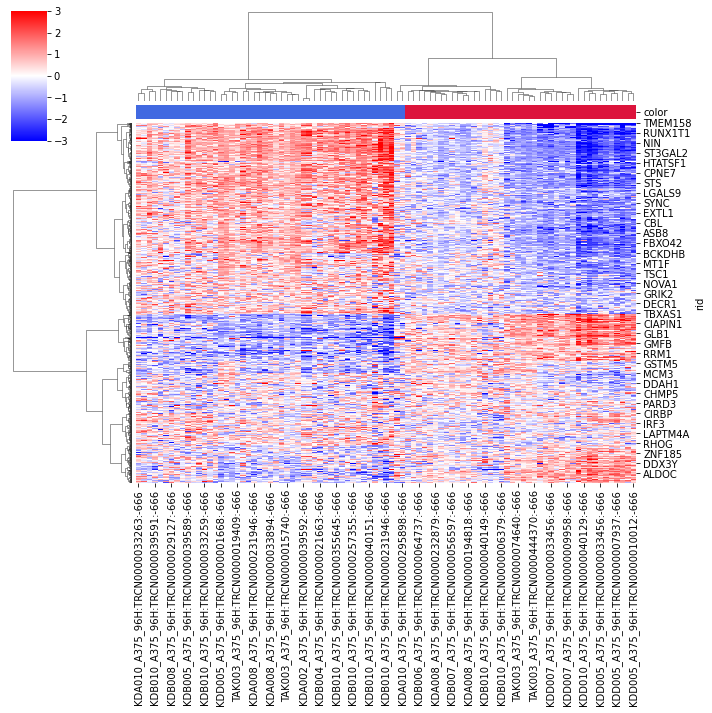

In [29]:
sns.clustermap(skcm_trt_sh_op_shift,
               vmin=-3, vmax=3, cmap='bwr', method='ward',
               col_colors=skcm_trt_sh_op_shift_color['color'])

In [31]:
skcm_sig_info[skcm_sig_info.index.isin(skcm_trt_sh_op_shift_color.index)]['pert_time'].value_counts()

96.0    91
Name: pert_time, dtype: int64

In [35]:
skcm_sig_info[skcm_sig_info.index.isin(skcm_trt_sh_op_shift_color.index)]['project_code'].value_counts()

KDB    36
KDD    22
KDA    18
TAK    12
KDC     3
Name: project_code, dtype: int64

In [38]:
skcm_sig_info[skcm_sig_info.index.isin(skcm_trt_sh_op_shift_color.index)]['bead_batch'].value_counts()

b4      51
f1b4    15
b7      12
b5       7
f1b3     3
f2b4     2
b3       1
Name: bead_batch, dtype: int64

In [133]:
# number of top hits on both side that are not belong to NREC or REC themselves
print(len(top_shift_REC[~top_shift_REC['cmap_name'].isin(gene_NREC)]['cmap_name'].unique()))
print(len(top_shift_NREC[~top_shift_NREC['cmap_name'].isin(gene_REC)]['cmap_name'].unique()))

690
177


In [134]:
# pathway analysis
# enrichment test: REC shifting
enrichr_top_shift_REC = gp.enrichr(gene_list=list(top_shift_REC[~top_shift_REC['cmap_name'].isin(gene_NREC)]['cmap_name'].unique()),
                                   gene_sets=['MSigDB_Hallmark_2020'],
                                   organism='Human',
                                   description='genes whose inhibition lead to REC',
                                   outdir='GSEA/REC_shifting_top_shRNA',
                                   cutoff=0.5)

# enrichment test: NREC shifting
enrichr_top_shift_NREC = gp.enrichr(gene_list=list(top_shift_NREC[~top_shift_NREC['cmap_name'].isin(gene_REC)]['cmap_name'].unique()),
                                   gene_sets=['MSigDB_Hallmark_2020'],
                                   organism='Human',
                                   description='sigenes whose inhibition lead to NREC',
                                   outdir='GSEA/NREC_shifting_top_shRNA',
                                   cutoff=0.5)

2022-01-26 17:31:45,152 Error fetching enrichment results: MSigDB_Hallmark_2020
2022-01-26 17:31:47,907 Error fetching enrichment results: MSigDB_Hallmark_2020


In [135]:
enrichr_top_shift_REC.results.head(20)

,Gene_set,Rank,Term,P-value,Z-score,Combined Score,Genes,Adjusted P-value,Old P-value,Old adjusted P-value
0,MSigDB_Hallmark_2020,1,p53 Pathway,1.193100e-11,5.117647,128.718449,BTG2;HDAC3;CD81;RGS16;CCP110;TGFA;ABAT;PPM1D;R...,5.965502e-10,0,0
1,MSigDB_Hallmark_2020,2,TNF-alpha Signaling via NF-kB,3.012635e-10,4.706176,103.173661,PTGER4;BTG2;B4GALT1;CEBPD;CXCL1;SAT1;ICAM1;IFI...,7.531587e-09,0,0
2,MSigDB_Hallmark_2020,3,UV Response Up,5.437915e-09,4.897829,93.205047,LYN;RET;BTG2;PARP2;IGFBP2;PRKCD;EPHX1;CEBPG;RA...,9.063192e-08,0,0
3,MSigDB_Hallmark_2020,4,Apoptosis,7.859522e-09,4.790605,89.400061,JUN;BTG2;GSTM1;SATB1;BIK;F2R;XIAP;CFLAR;SAT1;S...,9.824403e-08,0,0
4,MSigDB_Hallmark_2020,5,E2F Targets,2.788691e-08,4.110634,71.504920,CCP110;PSIP1;CTCF;PDS5B;PPM1D;AURKB;EXOSC8;USP...,2.323909e-07,0,0
5,MSigDB_Hallmark_2020,6,Glycolysis,2.788691e-08,4.110634,71.504920,B4GALT1;MPI;TGFA;AK3;HS2ST1;NT5E;UGP2;ME2;ANKZ...,2.323909e-07,0,0
6,MSigDB_Hallmark_2020,7,Fatty Acid Metabolism,1.247315e-07,4.393015,69.836208,AOC3;GABARAPL1;HMGCS1;ACSL1;EPHX1;UBE2L6;ACAT2...,8.909394e-07,0,0
7,MSigDB_Hallmark_2020,8,mTORC1 Signaling,1.716034e-06,3.539864,46.993447,MAP2K3;ACTR3;GSK3B;XBP1;BTG2;HMGCS1;INSIG1;RPA...,9.533523e-06,0,0
8,MSigDB_Hallmark_2020,9,Oxidative Phosphorylation,1.716034e-06,3.539864,46.993447,PDHX;ATP6V0B;NDUFA3;NDUFB2;NDUFA1;ETFA;COX5B;S...,9.533523e-06,0,0
9,MSigDB_Hallmark_2020,10,PI3K/AKT/mTOR Signaling,3.135708e-06,4.745679,60.140355,MAP2K3;ACTR3;GSK3B;ITPR2;RIT1;TBK1;LCK;DDIT3;S...,1.567854e-05,0,0


In [136]:
enrichr_top_shift_NREC.results.head(20)

,Gene_set,Rank,Term,P-value,Z-score,Combined Score,Genes,Adjusted P-value,Old P-value,Old adjusted P-value
0,MSigDB_Hallmark_2020,1,TNF-alpha Signaling via NF-kB,0.000419,4.839990,37.643800,PTGER4;JUN;SERPINB2;TNIP1;MAP3K8;KLF4;FOSL2;RHOB,0.006006,0,0
1,MSigDB_Hallmark_2020,2,Epithelial Mesenchymal Transition,0.000419,4.839990,37.643800,JUN;LGALS1;MMP1;PLOD3;VEGFC;PPIB;THBS1;RHOB,0.006006,0,0
2,MSigDB_Hallmark_2020,3,Oxidative Phosphorylation,0.000419,4.839990,37.643800,UQCRB;NDUFB6;MDH1;NDUFS6;NNT;IDH2;NDUFS4;VDAC1,0.006006,0,0
3,MSigDB_Hallmark_2020,4,Apoptosis,0.000587,5.259091,39.131096,JUN;DAP;IFNB1;CDK2;ERBB2;F2;RHOB,0.006309,0,0
4,MSigDB_Hallmark_2020,5,Coagulation,0.001447,5.234184,34.222800,SERPINB2;MMP1;CTSK;APOA1;F2;THBS1,0.012443,0,0
5,MSigDB_Hallmark_2020,6,Estrogen Response Early,0.008881,3.550190,16.770559,ELF1;ABHD2;FHL2;SFN;KLF4;CBFA2T3,0.063647,0,0
6,MSigDB_Hallmark_2020,7,Androgen Response,0.012039,4.751204,20.998550,RPS6KA3;CDK6;XRCC5;ABHD2,0.067789,0,0
7,MSigDB_Hallmark_2020,8,Fatty Acid Metabolism,0.013339,3.737270,16.134115,LGALS1;MDH1;PSME1;NBN;PPARA,0.067789,0,0
8,MSigDB_Hallmark_2020,9,PI3K/AKT/mTOR Signaling,0.014188,4.514851,19.212206,RPS6KA3;CDK2;E2F1;SFN,0.067789,0,0
9,MSigDB_Hallmark_2020,10,Complement,0.032816,2.926058,9.997847,SERPINB2;PIK3CA;ANXA5;F2;GNAI2,0.128282,0,0


(-0.38093049882205404, 0.011730822529871293)

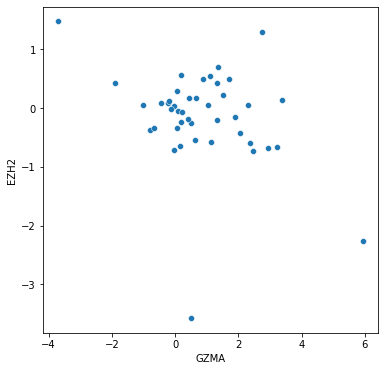

In [183]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='B2M', y='EZH2', data=log2exp2_91061_top_fc.T)
stats.pearsonr(log2exp2_91061_top_fc.T['B2M'], log2exp2_91061_top_fc.T['EZH2'])

In [184]:
stats.pearsonr(log2exp2_91061_top_fc.T['B2M'], log2exp2_91061_top_fc.T['EZH2'])

(-0.38093049882205404, 0.011730822529871293)

In [185]:
stats.pearsonr(log2exp2_91061_top_fc.T['GZMA'], log2exp2_91061_top_fc.T['EZH2'])

(-0.3419016574059638, 0.02482991368323642)

In [186]:
top_shift_REC_corr_91061 = df(columns=['B2M', 'TAP1', 'CD8A', 'HLA-A', 'HLA-B', 'HLA-C', 'GZMA'])
for g in top_shift_REC[~top_shift_REC['cmap_name'].isin(gene_NREC)]['cmap_name'].unique():
    if g in log2exp2_91061_top_fc.index:
        for g_c in top_shift_REC_corr_91061.columns:
            top_shift_REC_corr_91061.at[g, g_c] = stats.pearsonr(log2exp2_91061_top_fc.T[g], log2exp2_91061_top_fc.T[g_c])[0].astype(float)

top_shift_NREC_corr_91061 = df(columns=['B2M', 'TAP1', 'CD8A', 'HLA-A', 'HLA-B', 'HLA-C', 'GZMA'])
for g in top_shift_NREC[~top_shift_NREC['cmap_name'].isin(gene_REC)]['cmap_name'].unique():
    if g in log2exp2_91061_top_fc.index:
        for g_c in top_shift_NREC_corr_91061.columns:
            top_shift_NREC_corr_91061.at[g, g_c] = stats.pearsonr(log2exp2_91061_top_fc.T[g], log2exp2_91061_top_fc.T[g_c])[0].astype(float)

In [189]:
top_shift_REC_corr_91061.sort_values(by='B2M', ascending=True)[:10]

,B2M,TAP1,CD8A,HLA-A,HLA-B,HLA-C,GZMA
SKP2,-0.67007,-0.379399,-0.58261,-0.677424,-0.659938,-0.641262,-0.651606
ALDH18A1,-0.662725,-0.355367,-0.578923,-0.611731,-0.603323,-0.557564,-0.652628
MAST2,-0.631164,-0.334018,-0.396687,-0.375019,-0.502735,-0.505686,-0.514849
MTA1,-0.617698,-0.261464,-0.301613,-0.292301,-0.454979,-0.430881,-0.455326
CDK8,-0.603426,-0.264732,-0.595927,-0.55012,-0.612711,-0.636882,-0.675137
INTS3,-0.60076,-0.265966,-0.37982,-0.403089,-0.492982,-0.449373,-0.475848
SLC25A13,-0.600036,-0.147078,-0.505381,-0.495928,-0.564056,-0.497212,-0.617828
RRP12,-0.595476,-0.189793,-0.435025,-0.425341,-0.501251,-0.446145,-0.541145
DNM1L,-0.590191,-0.226931,-0.542218,-0.566217,-0.578011,-0.570609,-0.636979
SUPT16H,-0.58389,-0.219236,-0.455971,-0.493003,-0.526109,-0.537429,-0.584395


In [190]:
top_shift_REC_corr_91061.sort_values(by='GZMA', ascending=True)[:10]

,B2M,TAP1,CD8A,HLA-A,HLA-B,HLA-C,GZMA
CDK8,-0.603426,-0.264732,-0.595927,-0.55012,-0.612711,-0.636882,-0.675137
ALDH18A1,-0.662725,-0.355367,-0.578923,-0.611731,-0.603323,-0.557564,-0.652628
SKP2,-0.67007,-0.379399,-0.58261,-0.677424,-0.659938,-0.641262,-0.651606
DNM1L,-0.590191,-0.226931,-0.542218,-0.566217,-0.578011,-0.570609,-0.636979
KTN1,-0.561458,-0.394971,-0.586937,-0.553288,-0.508183,-0.585397,-0.629859
SLC25A13,-0.600036,-0.147078,-0.505381,-0.495928,-0.564056,-0.497212,-0.617828
WRN,-0.549546,-0.236506,-0.537334,-0.483049,-0.496284,-0.509993,-0.616225
KDM3A,-0.57316,-0.148573,-0.46212,-0.383555,-0.526409,-0.509153,-0.592283
SUPT16H,-0.58389,-0.219236,-0.455971,-0.493003,-0.526109,-0.537429,-0.584395
PPAT,-0.571525,-0.180882,-0.515161,-0.460753,-0.584422,-0.567694,-0.571387
